In [ ]:
!pip install pennylane

In [4]:
%%writefile ising_map.py
"""
ising_map.py

Utilities for mapping combinatorial optimization problems to Ising form
and computing objective values.

- graph_to_Ising_J(A): converts adjacency matrix A for Max-Cut into Ising coupling J
- cut_value(s, A): computes Max-Cut value for spin vector s in {+1,-1}
- ising_energy(s, J, h=None): computes Ising energy E = -0.5 s^T J s - h^T s
- random_weighted_graph(N, p_edge, w_scale): generate random weighted graph adjacency
"""

from typing import Optional, Tuple
import numpy as np


def graph_to_Ising_J(adj_matrix: np.ndarray) -> np.ndarray:
    """
    Convert adjacency matrix A (symmetric, zero diagonal) for Max-Cut into Ising coupling J.
    For Max-Cut we can use J = -A so that minimizing E_ising = -0.5 s^T J s corresponds to maximizing the cut.
    """
    A = np.array(adj_matrix, dtype=float)
    if A.shape[0] != A.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    J = -A.copy()
    np.fill_diagonal(J, 0.0)
    return J


def cut_value(s: np.ndarray, A: np.ndarray) -> float:
    """
    Compute Max-Cut value for spin vector s ∈ {+1, -1} and adjacency A:
      cut = 0.5 * sum_{i<j} A_ij (1 - s_i s_j)
    """
    s = np.array(s, dtype=int).reshape(-1)
    A = np.array(A, dtype=float)
    N = s.size
    if A.shape != (N, N):
        raise ValueError("Adjacency matrix size must match spin vector length.")
    # Efficient vectorized computation:
    # cut = 0.25 * sum_{i,j} A_ij (1 - s_i s_j)  (since each pair counted twice)
    return 0.25 * np.sum(A * (1.0 - np.outer(s, s)))


def ising_energy(s: np.ndarray, J: np.ndarray, h: Optional[np.ndarray] = None) -> float:
    """
    Compute Ising energy:
      E = -0.5 * s^T J s - h^T s
    """
    s = np.array(s, dtype=float).reshape(-1)
    J = np.array(J, dtype=float)
    if h is None:
        h = np.zeros_like(s)
    return -0.5 * float(s @ J @ s) - float(np.dot(h, s))


def random_weighted_graph(N: int, p_edge: float = 0.3, w_scale: float = 1.0, seed: Optional[int] = None) -> np.ndarray:
    """
    Generate a symmetric random weighted adjacency matrix A (zero diagonal).
    - N: number of nodes
    - p_edge: probability of an edge between i and j
    - w_scale: weight scaling factor (weights drawn ~ Uniform(0.5, 1.5) * w_scale)
    """
    rng = np.random.default_rng(seed)
    A = np.zeros((N, N), dtype=float)
    for i in range(N):
        for j in range(i + 1, N):
            if rng.random() < p_edge:
                val = rng.uniform(0.5, 1.5) * w_scale
                A[i, j] = val
                A[j, i] = val
    return A

Writing ising_map.py


In [5]:
%%writefile jj_physics.py
"""
jj_physics.py

Josephson-junction physics utilities:
- plasma frequency omega_p(i)
- washboard barrier delta_U(i)
- thermal escape rate gamma_th(i, T)
- macroscopic quantum tunnelling rate gamma_mqt(i)
- switching probability P_switch(i, t_p, T=None)

All formulas use SI units.
"""

from typing import Optional
import numpy as np

# Physical constants (SI)
h = 6.62607015e-34          # Planck constant [J·s]
hbar = 1.054571817e-34      # Reduced Planck constant [J·s]
e = 1.602176634e-19         # Elementary charge [C]
phi0 = h / (2 * e)          # Flux quantum [Wb]
kb = 1.380649e-23           # Boltzmann constant [J/K]

# Default device parameters (tunable)
DEFAULT_Ic = 1.0e-6    # Critical current [A]
DEFAULT_C  = 1.0e-12   # Junction capacitance [F]
DEFAULT_EJ = phi0 * DEFAULT_Ic / (2 * np.pi)


def omega_p(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C) -> float:
    """
    Plasma angular frequency ω_p(i) [rad/s] at reduced bias i = I/Ic.
    Uses underdamped tunnel-junction approximation:
      ω_p(i) = sqrt(2 e Ic / (ħ C)) * (1 - i^2)^(1/4)
    """
    i = float(i_reduced)
    i = np.clip(i, 0.0, 0.999999)
    return np.sqrt(2.0 * e * Ic / (hbar * C)) * (1.0 - i**2)**0.25


def delta_U(i_reduced: float, EJ: float = DEFAULT_EJ) -> float:
    """
    Washboard barrier height ΔU(i) [J] for a current-biased JJ:
      ΔU(i) = 2 EJ [ sqrt(1 - i^2) - i arccos(i) ]
    Valid for 0 <= i < 1.
    """
    i = float(i_reduced)
    i = np.clip(i, 0.0, 0.999999)
    return 2.0 * EJ * (np.sqrt(1.0 - i**2) - i * np.arccos(i))


def gamma_th(i_reduced: float, T: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
             EJ: float = DEFAULT_EJ) -> float:
    """
    Thermal (Kramers-like) escape rate Γ_th [1/s]:
      Γ_th ≈ (ω_p / 2π) * exp(-ΔU / (k_B T))
    Underdamped prefactor used (damping not explicitly included).
    """
    if T <= 0.0:
        return 0.0
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    exponent = - dU / (kb * T)
    # Avoid overflow / underflow for extreme numbers
    if exponent < -700:
        return 0.0
    return (op / (2.0 * np.pi)) * np.exp(exponent)


def gamma_mqt(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
              EJ: float = DEFAULT_EJ) -> float:
    """
    Macroscopic Quantum Tunneling (MQT) escape rate Γ_MQT [1/s], cubic-potential WKB approximation:
      Γ_MQT ≈ (ω_p / 2π) * sqrt(864 ΔU / (ħ ω_p)) * exp( -36 ΔU / (5 ħ ω_p) )
    """
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    arg = 36.0 * dU / (5.0 * hbar * op)
    if arg > 700:  # exponent too large -> rate virtually zero
        return 0.0
    # guard small denominators
    factor = max(1e-300, (864.0 * dU) / (hbar * op))
    pref = (op / (2.0 * np.pi)) * np.sqrt(factor)
    return pref * np.exp(-arg)


def P_switch(i_reduced: float, pulse_s: float, T: Optional[float] = None,
             Ic: float = DEFAULT_Ic, C: float = DEFAULT_C, EJ: float = DEFAULT_EJ,
             hbar_eff: float = hbar) -> float:
    if pulse_s <= 0.0:
        return 0.0
    gamma = gamma_mqt(i_reduced, Ic=Ic, C=C, EJ=EJ, hbar_eff=hbar_eff) if T is None \
            else gamma_th(i_reduced, T, Ic=Ic, C=C, EJ=EJ)
    lam = gamma * pulse_s
    lam = float(np.clip(lam, 0.0, 50.0))
    return 1.0 - np.exp(-lam)


def crossover_temperature(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C) -> float:
    """
    Rule-of-thumb crossover temperature T* ~ ħ ω_p / (2π k_B) at reduced bias i.
    Returns T* in Kelvins.
    """
    op = omega_p(i_reduced, Ic=Ic, C=C)
    return (hbar * op) / (2.0 * np.pi * kb)
def gamma_mqt(i_reduced: float, Ic: float = DEFAULT_Ic, C: float = DEFAULT_C,
              EJ: float = DEFAULT_EJ, hbar_eff: float = hbar) -> float:
    """
    Macroscopic Quantum Tunneling (MQT) escape rate with tunable effective Planck constant.
    """
    op = omega_p(i_reduced, Ic=Ic, C=C)
    dU = delta_U(i_reduced, EJ=EJ)
    arg = 36.0 * dU / (5.0 * hbar_eff * op)
    if arg > 700:  # exponent too large -> rate virtually zero
        return 0.0
    factor = max(1e-300, (864.0 * dU) / (hbar_eff * op))
    pref = (op / (2.0 * np.pi)) * np.sqrt(factor)
    return pref * np.exp(-arg)

Writing jj_physics.py



=== Running Max-Cut Quantum Optimization Use Case (N=8) ===

Running JJ-array simulations ...

Running classical Simulated Annealing ...

Running QAOA on same graph ...
QAOA step 0: exp_cut=10.4901
QAOA step 10: exp_cut=10.4901
QAOA step 20: exp_cut=10.4901
QAOA step 30: exp_cut=10.4901
QAOA step 40: exp_cut=10.4901

=== Results Summary ===
JJ MQT best cut:     2.4671
JJ Thermal best cut: 2.4671
SA best cut:         9.2224
QAOA best cut:       9.4994
QAOA exp cut:        10.4901


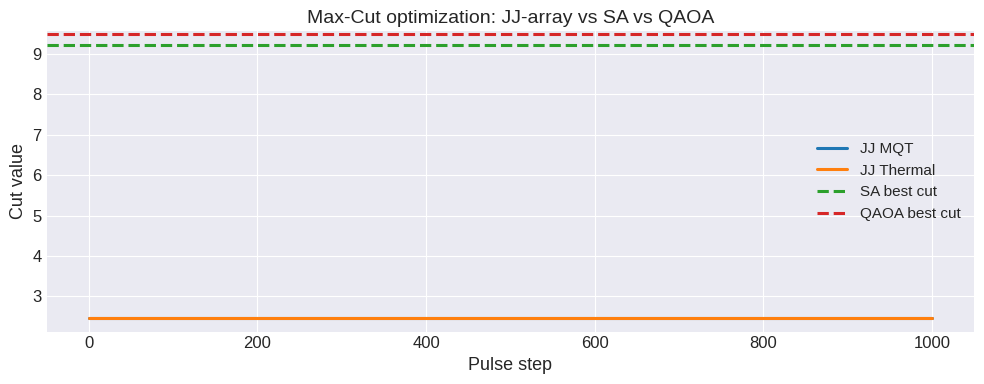

In [23]:
"""
maxcut_qc_usecase.py

Benchmark use case: MAX-CUT optimization solved via
- JJ-array pulse annealer (MQT and Thermal regimes)
- Classical Simulated Annealing
- Quantum Approximate Optimization Algorithm (QAOA via PennyLane)

This illustrates how combinatorial optimization (Max-Cut)
can be addressed by both hardware-inspired and quantum algorithms.

Run:
    python maxcut_qc_usecase.py
"""

import numpy as np
import matplotlib.pyplot as plt
import time
import pennylane as qml
from typing import Optional, Dict

# Import physics and Ising tools
from jj_physics import P_switch, kb
from ising_map import random_weighted_graph, graph_to_Ising_J, cut_value, ising_energy


# ---------------------------------------------------------
# Helper: Local field → reduced bias (same as your original)
# ---------------------------------------------------------
def local_field_to_reduced_bias(h_eff, i0=0.5, alpha=0.45, beta=1.0):
    h_eff = np.array(h_eff, dtype=float)
    return np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.9999)


# ---------------------------------------------------------
# JJ-array simulator (same as yours, cleaned for clarity)
# ---------------------------------------------------------
def jj_array_simulator(J: np.ndarray,
                       h: Optional[np.ndarray] = None,
                       pulse_s: float = 10e-6,
                       T: Optional[float] = None,
                       i0: float = 0.5,
                       alpha: float = 0.45,
                       beta: float = 1.0,
                       n_steps: int = 2000,
                       seed: Optional[int] = None,
                       verbose: bool = False) -> Dict:
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    s = rng.choice([-1, 1], size=N)
    energies, cut_vals = [], []
    best_cut = cut_value(s, -J)
    best_s = s.copy()
    energies.append(ising_energy(s, J, h))
    cut_vals.append(best_cut)
    flips_record = np.zeros(n_steps, dtype=int)

    for t in range(n_steps):
        h_eff = J @ s + h
        i_reduced = local_field_to_reduced_bias(h_eff, i0=i0, alpha=alpha, beta=beta)
        P = np.array([P_switch(float(i_reduced[i]), pulse_s, T) for i in range(N)])
        flips = np.random.rand(N) < P
        s[flips] *= -1
        E = ising_energy(s, J, h)
        cutv = cut_value(s, -J)
        flips_record[t] = flips.sum()
        energies.append(E)
        cut_vals.append(cutv)
        if cutv > best_cut:
            best_cut, best_s = cutv, s.copy()
        if verbose and (t % (n_steps // 10) == 0):
            print(f"[JJ {t}/{n_steps}] best_cut={best_cut:.3f}")
    return dict(energies=np.array(energies),
                cut_vals=np.array(cut_vals),
                best_cut=best_cut,
                best_s=best_s,
                flips_record=flips_record)


# ---------------------------------------------------------
# Classical Simulated Annealing
# ---------------------------------------------------------
def simulated_annealing(J: np.ndarray,
                        h: Optional[np.ndarray] = None,
                        T_start: float = 1.0,
                        T_end: float = 0.01,
                        n_steps: int = 2000,
                        seed: Optional[int] = None) -> Dict:
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    s = rng.choice([-1, 1], size=N)
    E = ising_energy(s, J, h)
    best_E, best_s = E, s.copy()
    energies = [E]
    temps = np.linspace(T_start, T_end, n_steps)
    for T in temps:
        i = rng.integers(0, N)
        s_new = s.copy()
        s_new[i] *= -1
        E_new = ising_energy(s_new, J, h)
        dE = E_new - E
        if dE < 0 or rng.random() < np.exp(-dE / (kb * max(T, 1e-12))):
            s, E = s_new, E_new
            if E < best_E:
                best_E, best_s = E, s.copy()
        energies.append(E)
    return dict(energies=np.array(energies), best_E=best_E, best_s=best_s)


# ---------------------------------------------------------
# Quantum solver: QAOA via PennyLane
# ---------------------------------------------------------
def qaoa_maxcut(A: np.ndarray, n_layers: int = 2) -> Dict:
    """
    Solve Max-Cut on graph A using QAOA implemented with PennyLane.
    """
    n = A.shape[0]
    edges = np.argwhere(A > 0)
    dev = qml.device("default.qubit", wires=n)  # analytic mode for optimization

    def cost_expectation(params):
        gammas, betas = params[0], params[1]
        @qml.qnode(dev)
        def circuit():
            for i in range(n):
                qml.Hadamard(i)
            for p in range(n_layers):
                for (i, j) in edges:
                    qml.CNOT(wires=[i, j])
                    qml.RZ(-2 * gammas[p] * A[i, j], wires=j)
                    qml.CNOT(wires=[i, j])
                for i in range(n):
                    qml.RX(2 * betas[p], wires=i)
            H = 0
            for (i, j) in edges:
                H += 0.5 * A[i, j] * (1 - qml.PauliZ(i) @ qml.PauliZ(j))
            return qml.expval(H)
        return circuit()

    # Optimize angles
    np.random.seed(42)
    gammas = np.random.uniform(0, np.pi, n_layers)
    betas = np.random.uniform(0, np.pi, n_layers)
    params = (gammas, betas)
    opt = qml.GradientDescentOptimizer(stepsize=0.2)

    for step in range(50):
        params = opt.step(cost_expectation, params)
        exp_cost = cost_expectation(params)
        if step % 10 == 0:
            print(f"QAOA step {step}: exp_cut={exp_cost:.4f}")

    # --- NEW: Sampling with finite shots ---
    dev_sample = qml.device("default.qubit", wires=n, shots=1024)

    @qml.qnode(dev_sample)
    def sample_circuit():
        for i in range(n):
            qml.Hadamard(i)
        for p in range(n_layers):
            for (i, j) in edges:
                qml.CNOT(wires=[i, j])
                qml.RZ(-2 * params[0][p] * A[i, j], wires=j)
                qml.CNOT(wires=[i, j])
            for i in range(n):
                qml.RX(2 * params[1][p], wires=i)
        return qml.sample(wires=range(n))

    # Draw samples (shots already handled by device)
    samples = np.array(sample_circuit())  # shape (shots, n)
    cuts = [cut_value(1 - 2 * s, A) for s in samples]
    best_cut = np.max(cuts)

    return dict(best_cut=best_cut, exp_cut=exp_cost, samples=samples, cuts=cuts)


# ---------------------------------------------------------
# Unified experiment
# ---------------------------------------------------------
def run_experiment(N=8):
    """
    Run Max-Cut instance using JJ-array, SA, and QAOA.
    """
    print(f"\n=== Running Max-Cut Quantum Optimization Use Case (N={N}) ===")
    A = random_weighted_graph(N, p_edge=0.4, w_scale=1.0, seed=42)
    J = graph_to_Ising_J(A)

    # --- JJ-array (MQT and Thermal) ---
    print("\nRunning JJ-array simulations ...")
    res_mqt = jj_array_simulator(J, T=None, n_steps=1000, seed=1)
    res_th = jj_array_simulator(J, T=0.05, n_steps=1000, seed=1)

    # --- SA baseline ---
    print("\nRunning classical Simulated Annealing ...")
    res_sa = simulated_annealing(J, n_steps=1000, seed=2)
    cut_sa = cut_value(res_sa["best_s"], A)

    # --- Quantum QAOA ---
    print("\nRunning QAOA on same graph ...")
    res_qaoa = qaoa_maxcut(A, n_layers=2)

    # --- Summary ---
    print("\n=== Results Summary ===")
    print(f"JJ MQT best cut:     {res_mqt['best_cut']:.4f}")
    print(f"JJ Thermal best cut: {res_th['best_cut']:.4f}")
    print(f"SA best cut:         {cut_sa:.4f}")
    print(f"QAOA best cut:       {res_qaoa['best_cut']:.4f}")
    print(f"QAOA exp cut:        {res_qaoa['exp_cut']:.4f}")

    # --- Plots ---
    plt.figure(figsize=(10, 4))
    plt.plot(res_mqt["cut_vals"], label="JJ MQT")
    plt.plot(res_th["cut_vals"], label="JJ Thermal")
    plt.axhline(y=cut_sa, color="C2", linestyle="--", label="SA best cut")
    plt.axhline(y=res_qaoa["best_cut"], color="C3", linestyle="--", label="QAOA best cut")
    plt.xlabel("Pulse step")
    plt.ylabel("Cut value")
    plt.title("Max-Cut optimization: JJ-array vs SA vs QAOA")
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_experiment(N=8)


In [31]:
%%writefile combinatorial_simulator.py
# combinatorial_simulator.py

import numpy as np
from typing import Optional, Dict
from jj_physics import P_switch, kb
from jj_physics import hbar

# Generic local field -> reduced bias mapping
def local_field_to_reduced_bias(h_eff: np.ndarray, i0: float = 0.5,
                                alpha: float = 0.45, beta: float = 1.0) -> np.ndarray:
    h_eff = np.array(h_eff, dtype=float)
    return np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.9999)


# Generic JJ-array pulse-based Monte Carlo simulator
def jj_array_optimizer(J: np.ndarray,
                       h: Optional[np.ndarray] = None,
                       pulse_s: float = 10e-6,
                       T: Optional[float] = None,
                       i0: float = 0.5,
                       alpha: float = 0.45,
                       beta: float = 1.0,
                       n_steps: int = 2000,
                       seed: Optional[int] = None,
                       verbose: bool = False,
                       cost_fn=None) -> Dict:
    """
    Generic combinatorial optimization solver using JJ-array tunneling (MQT or thermal).
    Arguments:
        J: NxN coupling matrix (Ising / QUBO)
        h: local field vector
        pulse_s: pulse width [s]
        T: temperature [K], None -> MQT
        i0, alpha, beta: reduced bias mapping
        n_steps: number of pulses
        cost_fn: optional function to evaluate custom cost (returns scalar)
    Returns:
        Dict with energies, best_solution, flips_record, final configuration
    """
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    s = rng.choice([-1, 1], size=N)
    energies = []
    flips_record = np.zeros(n_steps, dtype=int)

    # initial energy
    if cost_fn:
        E = cost_fn(s)
    else:
        E = s @ J @ s + np.sum(h * s)
    best_E = E
    best_s = s.copy()
    energies.append(E)

    for t in range(n_steps):
        h_eff = J @ s + h
        i_reduced = local_field_to_reduced_bias(h_eff, i0=i0, alpha=alpha, beta=beta)
        P = np.array([P_switch(float(i_reduced[i]), pulse_s, T) for i in range(N)])
        flips = rng.random(size=N) < P
        flips_record[t] = int(flips.sum())
        s[flips] *= -1

        if cost_fn:
            E = cost_fn(s)
        else:
            E = s @ J @ s + np.sum(h * s)

        energies.append(E)
        if E < best_E:
            best_E = E
            best_s = s.copy()

        if verbose and (t % max(1, n_steps // 10) == 0):
            print(f"[{t}/{n_steps}] E={E:.4f} best_E={best_E:.4f} flips={flips_record[t]}")

    return {
        'energies': np.array(energies),
        'best_E': float(best_E),
        'best_s': best_s,
        'final_s': s,
        'flips_record': flips_record
    }


# -----------------------------
# Example: Knapsack problem mapping
# -----------------------------
def knapsack_to_Ising(values, weights, W_max, lam=5.0):
    """
    Map Knapsack problem to Ising Hamiltonian: H = lambda*(sum(w_i s_i) - W_max)^2 - sum(v_i s_i)
    """
    n = len(values)
    J = np.zeros((n, n))
    h = -np.array(values, dtype=float)
    for i in range(n):
        for j in range(n):
            J[i, j] = lam * weights[i] * weights[j] / 4.0 if i != j else 0
        h[i] += lam * weights[i] * (weights[i] - 2 * W_max) / 2.0
    return J, h


# -----------------------------
# Usage example
# -----------------------------
if __name__ == "__main__":
    # Example: 10-item knapsack
    values = np.array([10, 8, 15, 4, 7, 6, 12, 5, 9, 11])
    weights = np.array([2, 3, 5, 1, 2, 2, 4, 1, 3, 4])
    W_max = 15

    J, h = knapsack_to_Ising(values, weights, W_max)

    result = jj_array_optimizer(J, h, pulse_s=1e-6, T=None, n_steps=1000, seed=42, verbose=True)

    print("Best energy:", result['best_E'])
    print("Best solution (spins):", result['best_s'])


Writing combinatorial_simulator.py


In [32]:
import numpy as np
from jj_physics import P_switch
from combinatorial_simulator import jj_array_optimizer
from ising_map import random_weighted_graph, graph_to_Ising_J, cut_value

# Max-Cut problem
N = 12
A = random_weighted_graph(N, p_edge=0.3, w_scale=1.0, seed=1)
J = graph_to_Ising_J(A)  # J = -A for Max-Cut
h = np.zeros(N)

# JJ-array pulse-based optimizer
res_mqt = jj_array_optimizer(J, h, pulse_s=1e-6, T=None, n_steps=500, seed=42)
res_th = jj_array_optimizer(J, h, pulse_s=1e-6, T=0.05, n_steps=500, seed=42)

print("MQT best cut:", cut_value(res_mqt['best_s'], A))
print("Thermal best cut:", cut_value(res_th['best_s'], A))


MQT best cut: 8.342150594768995
Thermal best cut: 6.277216864354305


In [33]:
from combinatorial_simulator import knapsack_to_Ising

values = np.array([10, 8, 15, 4, 7, 6, 12, 5, 9, 11])
weights = np.array([2, 3, 5, 1, 2, 2, 4, 1, 3, 4])
W_max = 15

J, h = knapsack_to_Ising(values, weights, W_max)

result = jj_array_optimizer(J, h, pulse_s=1e-6, T=None, n_steps=1000, seed=42)
print("Best energy:", result['best_E'])
print("Best solution (spins):", result['best_s'])


Best energy: 286.5
Best solution (spins): [-1  1  1 -1 -1  1 -1  1 -1 -1]


/usr/local/lib/python3.12/dist-packages/pennylane/_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Max-Cut Results:
MQT best cut: 2.460874428619796
Thermal best cut: 2.460874428619796
SA best cut: 0.5839784577477025
QAOA energy: 0.8941047177088449


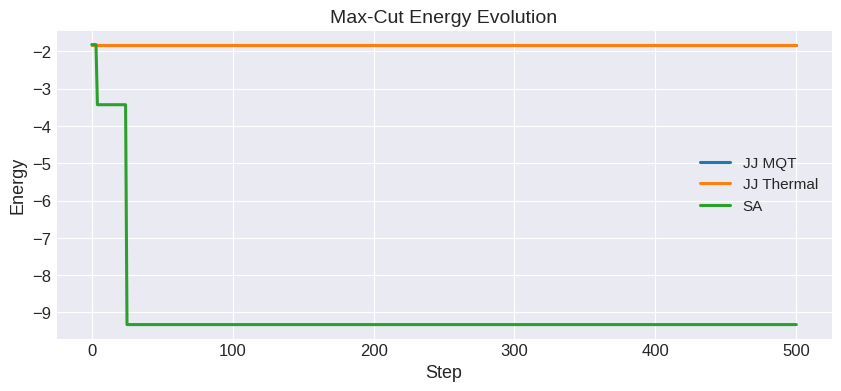


Knapsack Results:
MQT best energy: -191.0
Thermal best energy: -191.0
SA best energy: -80.0


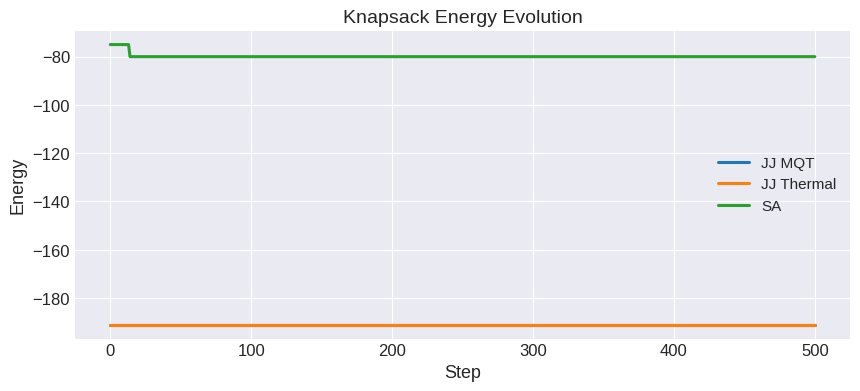

In [35]:
# integrated_combinatorial_solver.py

import numpy as np
import matplotlib.pyplot as plt
import time
from typing import Optional, Dict

from jj_physics import P_switch, kb

# Optional: PennyLane for QAOA
import pennylane as qml
from pennylane import numpy as pnp

# -----------------------------
# Generic JJ-array optimizer
# -----------------------------
def local_field_to_reduced_bias(h_eff: np.ndarray, i0: float = 0.5,
                                alpha: float = 0.45, beta: float = 1.0) -> np.ndarray:
    h_eff = np.array(h_eff, dtype=float)
    return np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.9999)

def jj_array_optimizer(J: np.ndarray,
                       h: Optional[np.ndarray] = None,
                       pulse_s: float = 10e-6,
                       T: Optional[float] = None,
                       i0: float = 0.5,
                       alpha: float = 0.45,
                       beta: float = 1.0,
                       n_steps: int = 2000,
                       seed: Optional[int] = None,
                       verbose: bool = False,
                       cost_fn=None) -> Dict:
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    s = rng.choice([-1, 1], size=N)
    energies = []
    flips_record = np.zeros(n_steps, dtype=int)

    if cost_fn:
        E = cost_fn(s)
    else:
        E = s @ J @ s + np.sum(h * s)
    best_E = E
    best_s = s.copy()
    energies.append(E)

    for t in range(n_steps):
        h_eff = J @ s + h
        i_reduced = local_field_to_reduced_bias(h_eff, i0=i0, alpha=alpha, beta=beta)
        P = np.array([P_switch(float(i_reduced[i]), pulse_s, T) for i in range(N)])
        flips = rng.random(size=N) < P
        flips_record[t] = int(flips.sum())
        s[flips] *= -1

        if cost_fn:
            E = cost_fn(s)
        else:
            E = s @ J @ s + np.sum(h * s)

        energies.append(E)
        if E < best_E:
            best_E = E
            best_s = s.copy()

        if verbose and (t % max(1, n_steps // 10) == 0):
            print(f"[{t}/{n_steps}] E={E:.4f} best_E={best_E:.4f} flips={flips_record[t]}")

    return {
        'energies': np.array(energies),
        'best_E': float(best_E),
        'best_s': best_s,
        'final_s': s,
        'flips_record': flips_record
    }

# -----------------------------
# Classical Simulated Annealing
# -----------------------------
def simulated_annealing(J: np.ndarray,
                        h: Optional[np.ndarray] = None,
                        T_start: float = 1.0,
                        T_end: float = 0.01,
                        n_steps: int = 2000,
                        seed: Optional[int] = None) -> Dict:
    rng = np.random.default_rng(seed)
    N = J.shape[0]
    if h is None:
        h = np.zeros(N)
    s = rng.choice([-1, 1], size=N)
    E = s @ J @ s + np.sum(h * s)
    best_E = E
    best_s = s.copy()
    energies = [E]
    temps = np.linspace(T_start, T_end, n_steps)
    for t, T in enumerate(temps):
        i = rng.integers(0, N)
        s_new = s.copy()
        s_new[i] *= -1
        E_new = s_new @ J @ s_new + np.sum(h * s_new)
        dE = E_new - E
        if dE < 0 or rng.random() < np.exp(-dE / (kb * max(T, 1e-300))):
            s = s_new
            E = E_new
        energies.append(E)
        if E < best_E:
            best_E = E
            best_s = s.copy()
    return {
        'energies': np.array(energies),
        'best_E': float(best_E),
        'best_s': best_s,
        'final_s': s
    }

# -----------------------------
# Max-Cut helpers
# -----------------------------
def random_weighted_graph(N, p_edge=0.3, w_scale=1.0, seed=None):
    rng = np.random.default_rng(seed)
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            if rng.random() < p_edge:
                w = rng.uniform(0, w_scale)
                A[i, j] = w
                A[j, i] = w
    return A

def graph_to_Ising_J(A):
    return -A  # Max-Cut: H = -sum_{i<j} A_ij s_i s_j

def cut_value(s, A):
    return 0.25 * np.sum(A * (1 - np.outer(s, s)))

# -----------------------------
# Knapsack helpers
# -----------------------------
def knapsack_to_Ising(values, weights, W_max, lam=5.0):
    n = len(values)
    J = np.zeros((n, n))
    h = -np.array(values, dtype=float)
    for i in range(n):
        for j in range(n):
            J[i, j] = lam * weights[i] * weights[j] / 4.0 if i != j else 0
        h[i] += lam * weights[i] * (weights[i] - 2 * W_max) / 2.0
    return J, h

# -----------------------------
# QAOA for small problems
# -----------------------------
def qaoa_optimizer(J, h, p=2, n_steps=100, lr=0.1, seed=42):
    N = len(h)
    dev = qml.device("default.qubit", wires=N)
    J = pnp.array(J, requires_grad=False)
    h = pnp.array(h, requires_grad=False)

    def cost_layer(gamma, beta):
        for i in range(N):
            qml.RX(2 * beta[i], wires=i)
        for i in range(N):
            for j in range(i+1, N):
                qml.IsingZZ(2 * gamma[0] * J[i, j], wires=[i, j])
            qml.RZ(2 * gamma[0] * h[i], wires=i)

    @qml.qnode(dev, interface="autograd")
    def circuit(params):
        gamma, beta = params
        for i in range(N):
            qml.Hadamard(wires=i)
        cost_layer(gamma, beta)
        return [qml.expval(qml.PauliZ(i)) for i in range(N)]

    # Initialize parameters
    gamma = 0.1 * np.ones(1)
    beta = 0.1 * np.ones(N)
    params = [gamma, beta]
    opt = qml.GradientDescentOptimizer(stepsize=lr)

    for _ in range(n_steps):
        params = opt.step(circuit, params)
    # Sample final solution
    measurements = circuit(params)
    s = np.array([1 if x < 0 else -1 for x in measurements])
    E = s @ J @ s + np.sum(h * s)
    return s, E

# -----------------------------
# Main workflow
# -----------------------------
if __name__ == "__main__":
    # ---- Max-Cut Example ----
    N = 8
    A = random_weighted_graph(N, p_edge=0.4, w_scale=1.0, seed=1)
    J = graph_to_Ising_J(A)
    h = np.zeros(N)

    res_mqt = jj_array_optimizer(J, h, pulse_s=1e-6, T=None, n_steps=500, seed=42)
    res_th = jj_array_optimizer(J, h, pulse_s=1e-6, T=0.05, n_steps=500, seed=42)
    res_sa = simulated_annealing(J, T_start=1.0, T_end=0.001, n_steps=500, seed=42)

    s_qaoa, E_qaoa = qaoa_optimizer(J, h, p=1, n_steps=50)

    print("Max-Cut Results:")
    print("MQT best cut:", cut_value(res_mqt['best_s'], A))
    print("Thermal best cut:", cut_value(res_th['best_s'], A))
    print("SA best cut:", cut_value(res_sa['best_s'], A))
    print("QAOA energy:", E_qaoa)

    # Plot energies
    plt.figure(figsize=(10, 4))
    plt.plot(res_mqt['energies'], label='JJ MQT')
    plt.plot(res_th['energies'], label='JJ Thermal')
    plt.plot(res_sa['energies'], label='SA')
    plt.xlabel('Step')
    plt.ylabel('Energy')
    plt.title('Max-Cut Energy Evolution')
    plt.legend()
    plt.show()

    # ---- Knapsack Example ----
    values = np.array([10, 8, 15, 4, 7, 6, 12, 5])
    weights = np.array([2, 3, 5, 1, 2, 2, 4, 1])
    W_max = 15

    J_k, h_k = knapsack_to_Ising(values, weights, W_max)

    res_mqt_k = jj_array_optimizer(J_k, h_k, pulse_s=1e-6, T=None, n_steps=500, seed=42)
    res_th_k = jj_array_optimizer(J_k, h_k, pulse_s=1e-6, T=0.05, n_steps=500, seed=42)
    res_sa_k = simulated_annealing(J_k, T_start=1.0, T_end=0.001, n_steps=500, seed=42)

    print("\nKnapsack Results:")
    print("MQT best energy:", res_mqt_k['best_E'])
    print("Thermal best energy:", res_th_k['best_E'])
    print("SA best energy:", res_sa_k['best_E'])

    plt.figure(figsize=(10, 4))
    plt.plot(res_mqt_k['energies'], label='JJ MQT')
    plt.plot(res_th_k['energies'], label='JJ Thermal')
    plt.plot(res_sa_k['energies'], label='SA')
    plt.xlabel('Step')
    plt.ylabel('Energy')
    plt.title('Knapsack Energy Evolution')
    plt.legend()
    plt.show()



QUANTUM-INSPIRED COMBINATORIAL OPTIMIZATION
Josephson Junction Arrays for NP-Hard Problems


>>> MAX-CUT PROBLEM <<<
Task: Partition graph vertices to maximize cut weight

Problem: MaxCutProblem (N=10)

Running: JJ Quantum Tunneling...
Running: JJ Thermal (T=0.05K)...
Running: Simulated Annealing...
Running: Greedy Heuristic...

Algorithm            Ising Energy    Problem Value  
--------------------------------------------------
JJ-Quantum                   -96.55          23.10
JJ-Thermal                   -96.55          23.10
SA                          -188.94           0.00
Greedy                       119.95          77.22


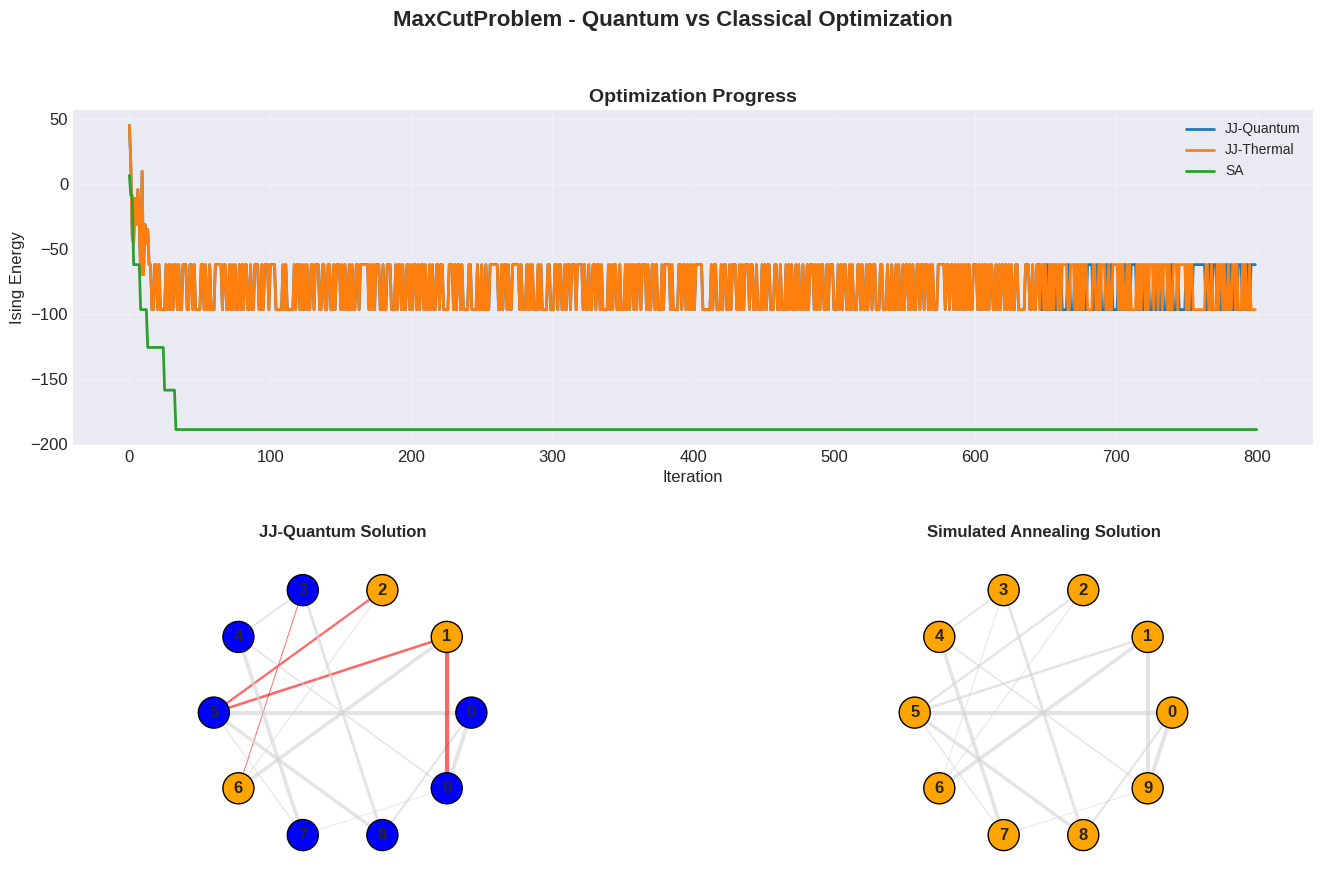



>>> 0-1 KNAPSACK PROBLEM <<<
Task: Select items to maximize value within weight capacity
Items: 12
Capacity: 49.0
Total available value: 169

Problem: KnapsackProblem (N=12)

Running: JJ Quantum Tunneling...
Running: JJ Thermal (T=0.05K)...
Running: Simulated Annealing...
Running: Greedy Heuristic...

Algorithm            Ising Energy    Problem Value  
--------------------------------------------------
JJ-Quantum                 -4028.50          71.00
JJ-Thermal                 -4028.50          71.00
SA                         -7098.50          51.00
Greedy                     -3814.50         125.00


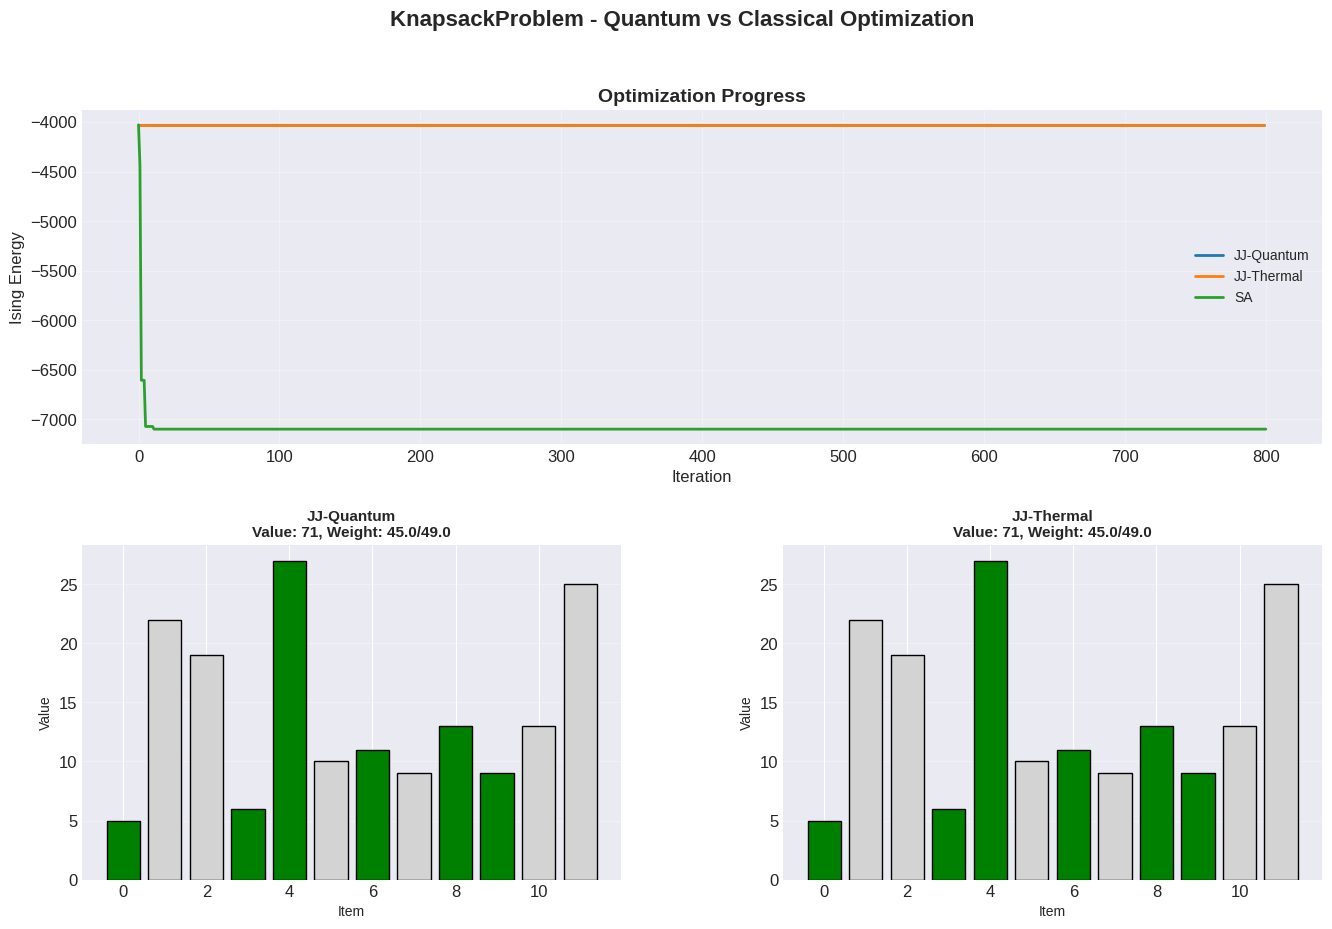


CONCLUSION


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Dict, Tuple
from dataclasses import dataclass

# Physical constants for JJ dynamics
kb = 1.380649e-23  # Boltzmann constant
P_SWITCH_BASE = 1e-6  # Base switching probability

def P_switch(i_reduced: float, pulse_s: float, T: Optional[float] = None) -> float:
    """Switching probability for a Josephson junction with quantum tunneling."""
    if i_reduced >= 1.0:
        return 1.0
    if i_reduced <= 0:
        return 0.0

    # Quantum tunneling contribution (dominant at low T)
    quantum_rate = np.exp(-10 * (1 - i_reduced))

    # Thermal contribution (if T is provided)
    thermal_rate = 0.0
    if T is not None and T > 0:
        thermal_rate = 0.1 * np.exp(-5 * (1 - i_reduced) / (kb * T * 1e23))

    total_rate = quantum_rate + thermal_rate
    return min(1.0, total_rate * pulse_s * 1e6)


@dataclass
class OptimizationResult:
    """Container for optimization results."""
    best_solution: np.ndarray
    best_cost: float
    cost_history: np.ndarray
    final_solution: np.ndarray
    algorithm: str
    problem_value: float = 0.0  # Max-cut value or knapsack value


# ============================================================================
# PROBLEM 1: MAX-CUT
# ============================================================================

class MaxCutProblem:
    """
    Max-Cut Problem: Partition graph vertices to maximize edge weights crossing partition.

    Given a weighted graph G=(V,E), find partition S ⊆ V that maximizes:
        Cut(S) = Σ_{i∈S, j∉S} w_ij

    This is equivalent to the Ising model with J_ij = -w_ij
    """

    def __init__(self, adjacency_matrix: np.ndarray):
        self.A = adjacency_matrix
        self.N = len(adjacency_matrix)
        self.J = -adjacency_matrix  # Ising coupling

    def cut_value(self, partition: np.ndarray) -> float:
        """Calculate cut value for a given partition (s_i ∈ {-1, +1})."""
        return 0.25 * np.sum(self.A * (1 - np.outer(partition, partition)))

    def ising_energy(self, spins: np.ndarray) -> float:
        """Ising energy (to minimize): E = -Cut(s)."""
        return spins @ self.J @ spins

    @staticmethod
    def random_graph(n_vertices: int, edge_prob: float = 0.4,
                    max_weight: float = 10.0, seed: Optional[int] = None) -> 'MaxCutProblem':
        """Generate random weighted graph."""
        rng = np.random.default_rng(seed)
        A = np.zeros((n_vertices, n_vertices))
        for i in range(n_vertices):
            for j in range(i+1, n_vertices):
                if rng.random() < edge_prob:
                    w = rng.uniform(1, max_weight)
                    A[i, j] = A[j, i] = w
        return MaxCutProblem(A)

    def visualize_solution(self, partition: np.ndarray, ax=None):
        """Visualize the graph partition."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))

        # Simple circular layout
        angles = np.linspace(0, 2*np.pi, self.N, endpoint=False)
        pos = np.column_stack([np.cos(angles), np.sin(angles)])

        # Draw edges
        for i in range(self.N):
            for j in range(i+1, self.N):
                if self.A[i, j] > 0:
                    color = 'red' if partition[i] != partition[j] else 'lightgray'
                    width = self.A[i, j] / np.max(self.A) * 3
                    ax.plot([pos[i, 0], pos[j, 0]], [pos[i, 1], pos[j, 1]],
                           color=color, linewidth=width, alpha=0.6, zorder=1)

        # Draw vertices
        colors = ['blue' if s > 0 else 'orange' for s in partition]
        ax.scatter(pos[:, 0], pos[:, 1], c=colors, s=500, zorder=2, edgecolors='black')
        for i, (x, y) in enumerate(pos):
            ax.text(x, y, str(i), ha='center', va='center', fontsize=12, fontweight='bold')

        ax.set_xlim(-1.3, 1.3)
        ax.set_ylim(-1.3, 1.3)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(f'Max-Cut Solution (Cut Value: {self.cut_value(partition):.1f})')


# ============================================================================
# PROBLEM 2: KNAPSACK
# ============================================================================

class KnapsackProblem:
    """
    0-1 Knapsack Problem: Select items to maximize value without exceeding capacity.

    Given items with values v_i and weights w_i, and capacity W, maximize:
        Σ v_i x_i  subject to  Σ w_i x_i ≤ W,  x_i ∈ {0,1}

    Encoded as Ising model with penalty for constraint violation.
    """

    def __init__(self, values: np.ndarray, weights: np.ndarray, capacity: float, penalty: float = 10.0):
        self.values = np.array(values)
        self.weights = np.array(weights)
        self.capacity = capacity
        self.penalty = penalty
        self.N = len(values)
        self.J, self.h = self._to_ising()

    def _to_ising(self) -> Tuple[np.ndarray, np.ndarray]:
        """Convert knapsack to Ising model with penalty method."""
        n = self.N
        J = np.zeros((n, n))
        h = np.zeros(n)

        # Penalty term: λ(Σw_i x_i - W)² where x_i = (1-s_i)/2
        for i in range(n):
            for j in range(n):
                if i != j:
                    J[i, j] = self.penalty * self.weights[i] * self.weights[j] / 4.0
            h[i] = -self.values[i]/2 + self.penalty * self.weights[i] * (self.weights[i] - 2*self.capacity) / 4.0

        return J, h

    def spin_to_binary(self, spins: np.ndarray) -> np.ndarray:
        """Convert spins {-1,+1} to binary {0,1}."""
        return ((1 - spins) / 2).astype(int)

    def evaluate(self, spins: np.ndarray) -> Dict[str, float]:
        """Evaluate knapsack solution."""
        x = self.spin_to_binary(spins)
        total_value = np.sum(self.values * x)
        total_weight = np.sum(self.weights * x)
        feasible = total_weight <= self.capacity
        return {
            'value': total_value,
            'weight': total_weight,
            'feasible': feasible,
            'violation': max(0, total_weight - self.capacity)
        }

    def ising_energy(self, spins: np.ndarray) -> float:
        """Ising energy including penalty."""
        return spins @ self.J @ spins + np.sum(self.h * spins)

    @staticmethod
    def random_instance(n_items: int, seed: Optional[int] = None) -> 'KnapsackProblem':
        """Generate random knapsack instance."""
        rng = np.random.default_rng(seed)
        values = rng.integers(5, 30, size=n_items)
        weights = rng.integers(1, 15, size=n_items)
        capacity = np.sum(weights) * 0.5  # 50% of total weight
        return KnapsackProblem(values, weights, capacity)


# ============================================================================
# OPTIMIZATION ALGORITHMS
# ============================================================================

def josephson_optimizer(problem, mode: str = 'quantum', n_steps: int = 1000,
                       temperature: Optional[float] = None, seed: Optional[int] = None) -> OptimizationResult:
    """
    Solve optimization problem using Josephson junction array dynamics.

    Args:
        problem: MaxCutProblem or KnapsackProblem instance
        mode: 'quantum' (pure tunneling) or 'thermal' (with thermal activation)
        n_steps: Number of evolution steps
        temperature: Temperature for thermal mode (K)
        seed: Random seed
    """
    rng = np.random.default_rng(seed)
    N = problem.N
    J = problem.J if hasattr(problem, 'J') else problem.J
    h = np.zeros(N) if not hasattr(problem, 'h') else problem.h

    # Initialize random spin configuration
    spins = rng.choice([-1, 1], size=N)

    cost_history = []
    best_cost = np.inf
    best_spins = spins.copy()

    # Dynamics parameters
    pulse_duration = 1e-6  # 1 microsecond pulses
    i0 = 0.5  # Bias current offset
    alpha = 0.45  # Field coupling strength
    beta = 1.0  # Nonlinearity parameter

    T = temperature if mode == 'thermal' else None

    for step in range(n_steps):
        # Calculate effective field on each junction
        h_eff = J @ spins + h

        # Map field to reduced bias current
        i_reduced = np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.999)

        # Calculate switching probabilities (quantum tunneling + thermal)
        P = np.array([P_switch(ir, pulse_duration, T) for ir in i_reduced])

        # Stochastic spin flips
        flips = rng.random(size=N) < P
        spins[flips] *= -1

        # Evaluate current solution
        cost = problem.ising_energy(spins)
        cost_history.append(cost)

        if cost < best_cost:
            best_cost = cost
            best_spins = spins.copy()

    # Calculate problem-specific value
    if isinstance(problem, MaxCutProblem):
        problem_value = problem.cut_value(best_spins)
    else:  # KnapsackProblem
        result = problem.evaluate(best_spins)
        problem_value = result['value'] if result['feasible'] else 0

    return OptimizationResult(
        best_solution=best_spins,
        best_cost=best_cost,
        cost_history=np.array(cost_history),
        final_solution=spins,
        algorithm=f'JJ-{mode}',
        problem_value=problem_value
    )


def simulated_annealing(problem, n_steps: int = 1000, T_start: float = 2.0,
                       T_end: float = 0.01, seed: Optional[int] = None) -> OptimizationResult:
    """Classical simulated annealing solver."""
    rng = np.random.default_rng(seed)
    N = problem.N
    J = problem.J if hasattr(problem, 'J') else problem.J
    h = np.zeros(N) if not hasattr(problem, 'h') else problem.h

    spins = rng.choice([-1, 1], size=N)
    cost = problem.ising_energy(spins)
    best_cost = cost
    best_spins = spins.copy()
    cost_history = [cost]

    temps = np.linspace(T_start, T_end, n_steps)

    for T in temps:
        # Propose random spin flip
        i = rng.integers(0, N)
        spins[i] *= -1
        new_cost = problem.ising_energy(spins)
        delta_cost = new_cost - cost

        # Metropolis criterion
        if delta_cost < 0 or rng.random() < np.exp(-delta_cost / (kb * T * 1e23)):
            cost = new_cost
        else:
            spins[i] *= -1  # Reject

        cost_history.append(cost)

        if cost < best_cost:
            best_cost = cost
            best_spins = spins.copy()

    if isinstance(problem, MaxCutProblem):
        problem_value = problem.cut_value(best_spins)
    else:
        result = problem.evaluate(best_spins)
        problem_value = result['value'] if result['feasible'] else 0

    return OptimizationResult(
        best_solution=best_spins,
        best_cost=best_cost,
        cost_history=np.array(cost_history),
        final_solution=spins,
        algorithm='Simulated Annealing',
        problem_value=problem_value
    )


def greedy_solver(problem) -> OptimizationResult:
    """Simple greedy heuristic for comparison."""
    if isinstance(problem, MaxCutProblem):
        # Start with random partition, greedily improve
        spins = np.ones(problem.N)
        for i in range(problem.N):
            spins[i] = -1
            if problem.cut_value(spins) < problem.cut_value(spins * np.array([1 if j != i else -1 for j in range(problem.N)])):
                spins[i] = 1
        problem_value = problem.cut_value(spins)
    else:  # Knapsack
        # Sort by value/weight ratio
        ratios = problem.values / problem.weights
        indices = np.argsort(ratios)[::-1]
        spins = np.ones(problem.N)  # Start with nothing (spins=1 means x=0)
        weight = 0
        for i in indices:
            if weight + problem.weights[i] <= problem.capacity:
                spins[i] = -1  # Include item
                weight += problem.weights[i]
        result = problem.evaluate(spins)
        problem_value = result['value']

    cost = problem.ising_energy(spins)
    return OptimizationResult(
        best_solution=spins,
        best_cost=cost,
        cost_history=np.array([cost]),
        final_solution=spins,
        algorithm='Greedy',
        problem_value=problem_value
    )


# ============================================================================
# COMPARISON AND VISUALIZATION
# ============================================================================

def compare_solvers(problem, n_steps: int = 1000, seed: int = 42):
    """Run all solvers and compare results."""
    print(f"\n{'='*70}")
    print(f"Problem: {problem.__class__.__name__} (N={problem.N})")
    print(f"{'='*70}\n")

    results = {}

    # Josephson Junction (Quantum Tunneling)
    print("Running: JJ Quantum Tunneling...")
    results['JJ-Quantum'] = josephson_optimizer(problem, mode='quantum', n_steps=n_steps, seed=seed)

    # Josephson Junction (Thermal)
    print("Running: JJ Thermal (T=0.05K)...")
    results['JJ-Thermal'] = josephson_optimizer(problem, mode='thermal', n_steps=n_steps,
                                                temperature=0.05, seed=seed)

    # Simulated Annealing
    print("Running: Simulated Annealing...")
    results['SA'] = simulated_annealing(problem, n_steps=n_steps, seed=seed)

    # Greedy
    print("Running: Greedy Heuristic...")
    results['Greedy'] = greedy_solver(problem)

    # Print results
    print(f"\n{'Algorithm':<20} {'Ising Energy':<15} {'Problem Value':<15}")
    print("-" * 50)
    for name, result in results.items():
        print(f"{name:<20} {result.best_cost:>14.2f} {result.problem_value:>14.2f}")

    # Visualization
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    # Energy evolution
    ax1 = fig.add_subplot(gs[0, :])
    for name, result in results.items():
        if len(result.cost_history) > 1:
            ax1.plot(result.cost_history, label=name, linewidth=2)
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Ising Energy', fontsize=12)
    ax1.set_title('Optimization Progress', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(alpha=0.3)

    # Best solutions visualization
    if isinstance(problem, MaxCutProblem):
        ax2 = fig.add_subplot(gs[1, 0])
        problem.visualize_solution(results['JJ-Quantum'].best_solution, ax=ax2)
        ax2.set_title('JJ-Quantum Solution', fontsize=12, fontweight='bold')

        ax3 = fig.add_subplot(gs[1, 1])
        problem.visualize_solution(results['SA'].best_solution, ax=ax3)
        ax3.set_title('Simulated Annealing Solution', fontsize=12, fontweight='bold')

    else:  # Knapsack
        # Show selected items
        for idx, (name, result) in enumerate(list(results.items())[:2]):
            ax = fig.add_subplot(gs[1, idx])
            eval_result = problem.evaluate(result.best_solution)
            selected = problem.spin_to_binary(result.best_solution)

            colors = ['green' if s else 'lightgray' for s in selected]
            bars = ax.bar(range(problem.N), problem.values, color=colors, edgecolor='black')
            ax.set_xlabel('Item', fontsize=10)
            ax.set_ylabel('Value', fontsize=10)
            ax.set_title(f"{name}\nValue: {eval_result['value']:.0f}, "
                        f"Weight: {eval_result['weight']:.1f}/{problem.capacity:.1f}",
                        fontsize=11, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)

    plt.suptitle(f"{problem.__class__.__name__} - Quantum vs Classical Optimization",
                 fontsize=16, fontweight='bold')
    plt.show()

    return results


# ============================================================================
# MAIN DEMONSTRATION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("QUANTUM-INSPIRED COMBINATORIAL OPTIMIZATION")
    print("Josephson Junction Arrays for NP-Hard Problems")
    print("="*70)

    # ========== MAX-CUT PROBLEM ==========
    print("\n\n>>> MAX-CUT PROBLEM <<<")
    print("Task: Partition graph vertices to maximize cut weight")

    maxcut = MaxCutProblem.random_graph(n_vertices=10, edge_prob=0.4, max_weight=10, seed=42)
    maxcut_results = compare_solvers(maxcut, n_steps=800, seed=42)

    # ========== KNAPSACK PROBLEM ==========
    print("\n\n>>> 0-1 KNAPSACK PROBLEM <<<")
    print("Task: Select items to maximize value within weight capacity")

    knapsack = KnapsackProblem.random_instance(n_items=12, seed=123)
    print(f"Items: {knapsack.N}")
    print(f"Capacity: {knapsack.capacity:.1f}")
    print(f"Total available value: {np.sum(knapsack.values)}")

    knapsack_results = compare_solvers(knapsack, n_steps=800, seed=42)

    print("\n" + "="*70)
    print("CONCLUSION")
    print("="*70)



QUANTUM vs CLASSICAL COMBINATORIAL OPTIMIZATION
Comprehensive Benchmark: QAOA, VQE, Josephson Junctions, Classical Methods


▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶
TEST CASE 1: MAX-CUT PROBLEM
▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶▶

Objective: Partition graph to maximize edges crossing the cut
Graph: 8 vertices, 14 edges

COMPREHENSIVE OPTIMIZATION BENCHMARK
Problem: MaxCutProblem (N=8)

🔮 QUANTUM ALGORITHMS (PennyLane)
--------------------------------------------------------------------------------
  Running QAOA (p=2)...


/usr/local/lib/python3.12/dist-packages/pennylane/_grad.py:310: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


  Running QAOA (p=3)...
  Running VQE (3 layers)...

⚛️  JOSEPHSON JUNCTION ARRAYS (Physical Quantum Hardware)
--------------------------------------------------------------------------------
  Running JJ Quantum Tunneling...
  Running JJ Thermal (T=0.05K)...

💻 CLASSICAL ALGORITHMS
--------------------------------------------------------------------------------
  Running Simulated Annealing...
  Running Greedy Heuristic...

RESULTS SUMMARY
Algorithm            Type            Value        Energy       Time(s)    Iters   
--------------------------------------------------------------------------------
QAOA-2               Quantum-Gate          46.17        0.00     4.793     200
QAOA-3               Quantum-Gate          44.38       -0.00     6.446     200
VQE-3                Quantum-Gate           0.00     -179.13    16.245     200
JJ-Quantum           Quantum-Anneal        26.02      -75.05     0.037     400
JJ-Thermal           Quantum-Anneal        26.02      -75.05     0.045     

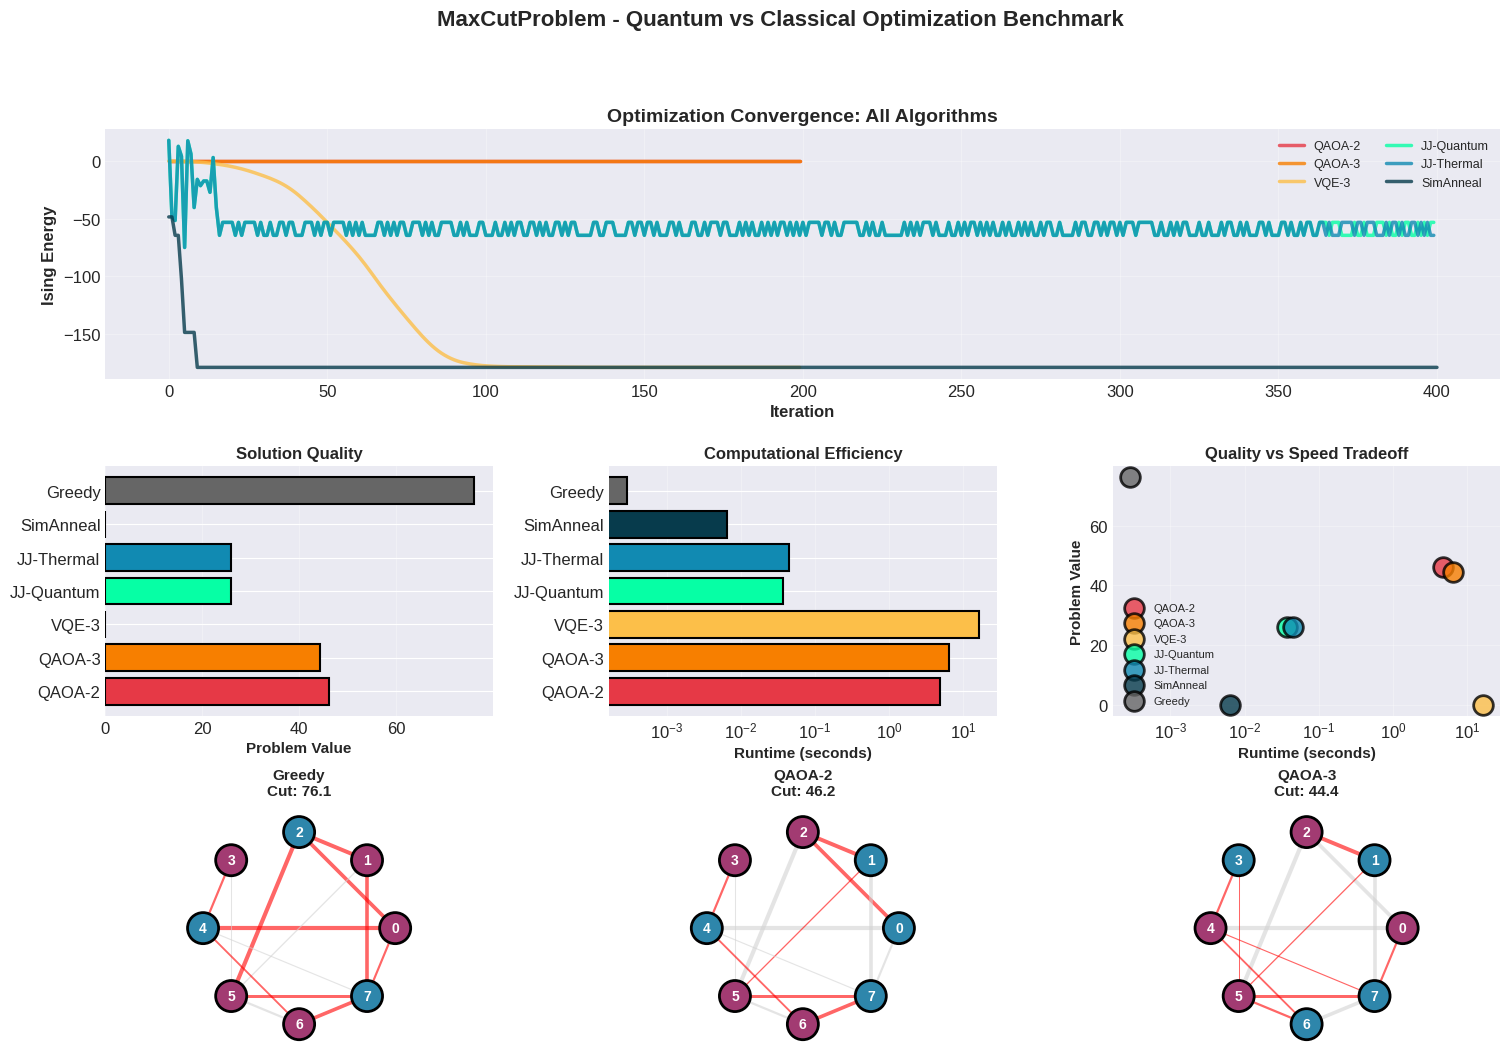


DETAILED ANALYSIS

📊 ALGORITHM COMPARISON:

  Best Quantum Gate-Based: QAOA-2
    → Value: 46.17
    → Runtime: 4.793s
    → Advantage: Uses universal quantum gates, works on gate-model quantum computers

  Best Quantum Annealing: JJ-Quantum
    → Value: 26.02
    → Runtime: 0.037s
    → Advantage: Physical implementation (JJ arrays), natural for optimization

  Best Classical: Greedy
    → Value: 76.14
    → Runtime: 0.000s
    → Advantage: Mature, well-understood, efficient implementation


🎯 CONVERGENCE CHARACTERISTICS:

  QAOA-2:
    → Improvement: 0.00
    → 90% convergence at: 100.0% of iterations
  QAOA-3:
    → Improvement: 0.00
    → 90% convergence at: 100.0% of iterations
  VQE-3:
    → Improvement: 179.08
    → 90% convergence at: 42.0% of iterations
  JJ-Quantum:
    → Improvement: 71.19
    → 90% convergence at: 0.2% of iterations
  JJ-Thermal:
    → Improvement: 82.44
    → 90% convergence at: 1.2% of iterations
  SimAnneal:
    → Improvement: 130.60
    → 90% convergen

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10003 (\N{CHECK MARK}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


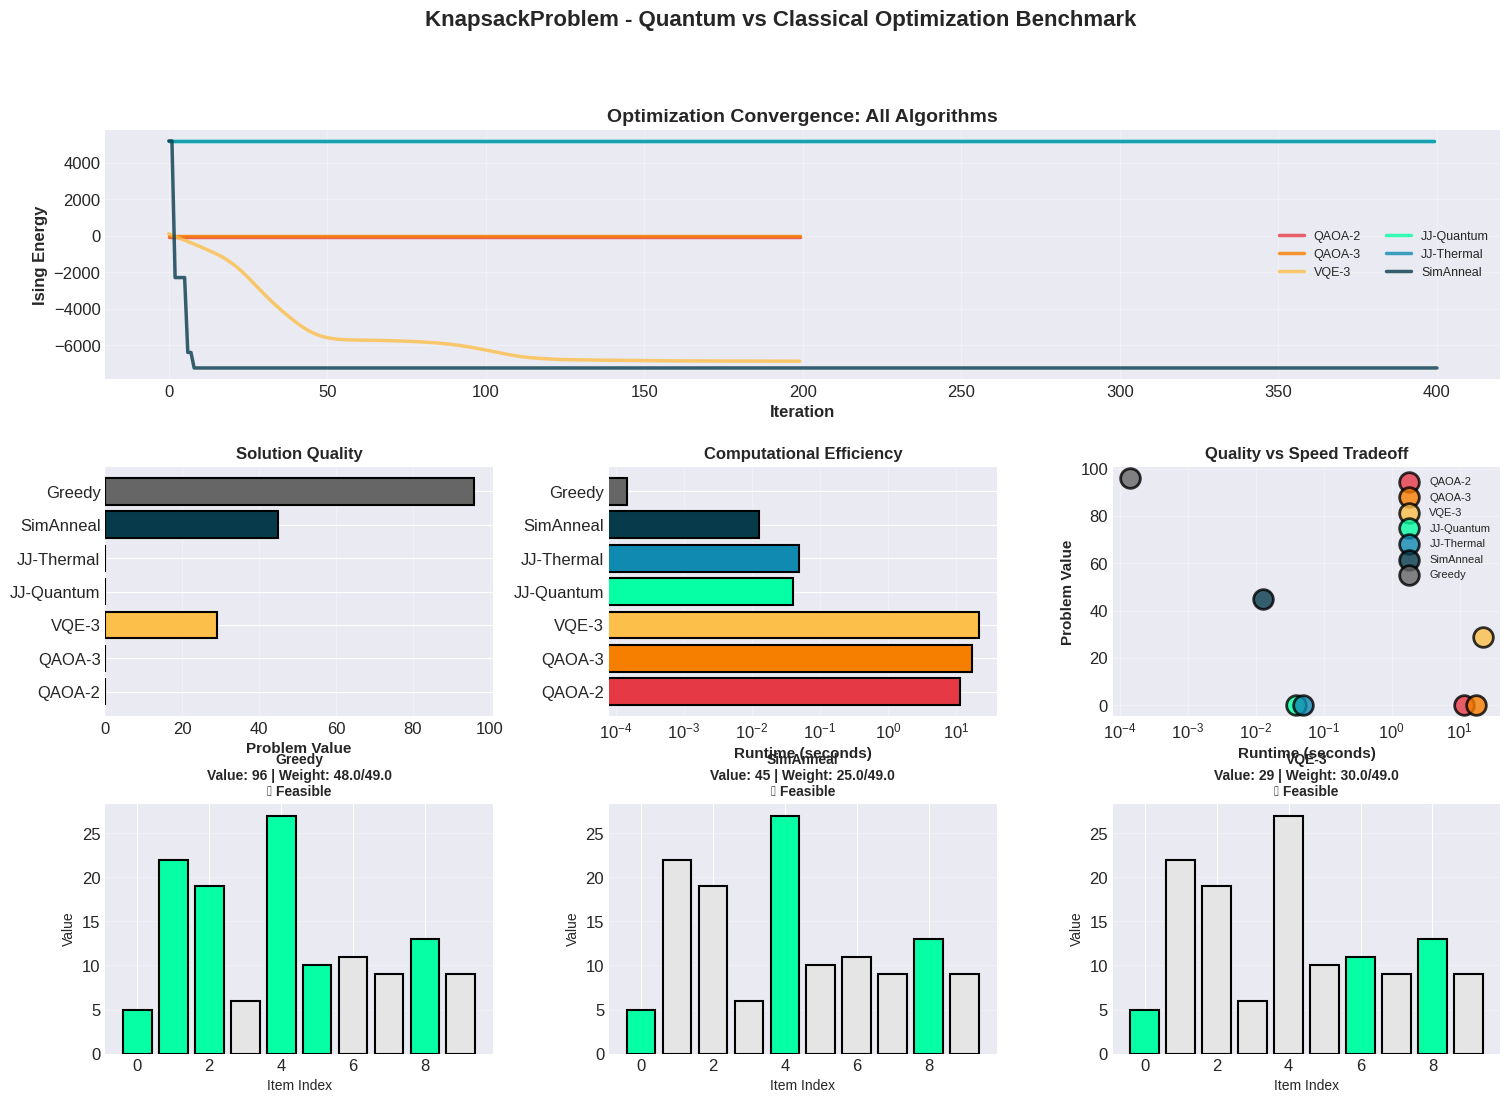


DETAILED ANALYSIS

📊 ALGORITHM COMPARISON:

  Best Quantum Gate-Based: VQE-3
    → Value: 29.00
    → Runtime: 21.839s
    → Advantage: Uses universal quantum gates, works on gate-model quantum computers

  Best Quantum Annealing: JJ-Quantum
    → Value: 0.00
    → Runtime: 0.040s
    → Advantage: Physical implementation (JJ arrays), natural for optimization

  Best Classical: Greedy
    → Value: 96.00
    → Runtime: 0.000s
    → Advantage: Mature, well-understood, efficient implementation


🎯 CONVERGENCE CHARACTERISTICS:

  QAOA-2:
    → Improvement: 0.00
    → 90% convergence at: 100.0% of iterations
  QAOA-3:
    → Improvement: 0.00
    → 90% convergence at: 100.0% of iterations
  VQE-3:
    → Improvement: 6980.01
    → 90% convergence at: 49.0% of iterations
  JJ-Quantum:
    → Improvement: 0.00
    → 90% convergence at: 100.0% of iterations
  JJ-Thermal:
    → Improvement: 0.00
    → 90% convergence at: 100.0% of iterations
  SimAnneal:
    → Improvement: 12436.00
    → 90% conve

In [38]:
"""
Quantum-Inspired Combinatorial Optimization Suite
Compares Josephson Junction Arrays, Quantum Algorithms (QAOA, VQE), and Classical Methods
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Dict, Tuple, List
from dataclasses import dataclass
import time

# Quantum computing with PennyLane
import pennylane as qml
from pennylane import numpy as pnp

# Physical constants for JJ dynamics
kb = 1.380649e-23  # Boltzmann constant
P_SWITCH_BASE = 1e-6  # Base switching probability

def P_switch(i_reduced: float, pulse_s: float, T: Optional[float] = None) -> float:
    """Switching probability for a Josephson junction with quantum tunneling."""
    if i_reduced >= 1.0:
        return 1.0
    if i_reduced <= 0:
        return 0.0

    # Quantum tunneling contribution (dominant at low T)
    quantum_rate = np.exp(-10 * (1 - i_reduced))

    # Thermal contribution (if T is provided)
    thermal_rate = 0.0
    if T is not None and T > 0:
        thermal_rate = 0.1 * np.exp(-5 * (1 - i_reduced) / (kb * T * 1e23))

    total_rate = quantum_rate + thermal_rate
    return min(1.0, total_rate * pulse_s * 1e6)


@dataclass
class OptimizationResult:
    """Container for optimization results."""
    best_solution: np.ndarray
    best_cost: float
    cost_history: np.ndarray
    final_solution: np.ndarray
    algorithm: str
    problem_value: float = 0.0
    runtime: float = 0.0
    iterations: int = 0


# ============================================================================
# PROBLEM 1: MAX-CUT
# ============================================================================

class MaxCutProblem:
    """
    Max-Cut Problem: Partition graph vertices to maximize edge weights crossing partition.

    Given a weighted graph G=(V,E), find partition S ⊆ V that maximizes:
        Cut(S) = Σ_{i∈S, j∉S} w_ij

    This is equivalent to the Ising model with J_ij = -w_ij
    """

    def __init__(self, adjacency_matrix: np.ndarray):
        self.A = adjacency_matrix
        self.N = len(adjacency_matrix)
        self.J = -adjacency_matrix  # Ising coupling
        self.h = np.zeros(self.N)   # No external field for max-cut

    def cut_value(self, partition: np.ndarray) -> float:
        """Calculate cut value for a given partition (s_i ∈ {-1, +1})."""
        return 0.25 * np.sum(self.A * (1 - np.outer(partition, partition)))

    def ising_energy(self, spins: np.ndarray) -> float:
        """Ising energy (to minimize): E = -Cut(s)."""
        return spins @ self.J @ spins

    @staticmethod
    def random_graph(n_vertices: int, edge_prob: float = 0.4,
                    max_weight: float = 10.0, seed: Optional[int] = None) -> 'MaxCutProblem':
        """Generate random weighted graph."""
        rng = np.random.default_rng(seed)
        A = np.zeros((n_vertices, n_vertices))
        for i in range(n_vertices):
            for j in range(i+1, n_vertices):
                if rng.random() < edge_prob:
                    w = rng.uniform(1, max_weight)
                    A[i, j] = A[j, i] = w
        return MaxCutProblem(A)

    def visualize_solution(self, partition: np.ndarray, ax=None):
        """Visualize the graph partition."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))

        # Simple circular layout
        angles = np.linspace(0, 2*np.pi, self.N, endpoint=False)
        pos = np.column_stack([np.cos(angles), np.sin(angles)])

        # Draw edges
        for i in range(self.N):
            for j in range(i+1, self.N):
                if self.A[i, j] > 0:
                    color = 'red' if partition[i] != partition[j] else 'lightgray'
                    width = self.A[i, j] / np.max(self.A) * 3
                    ax.plot([pos[i, 0], pos[j, 0]], [pos[i, 1], pos[j, 1]],
                           color=color, linewidth=width, alpha=0.6, zorder=1)

        # Draw vertices
        colors = ['#2E86AB' if s > 0 else '#A23B72' for s in partition]
        ax.scatter(pos[:, 0], pos[:, 1], c=colors, s=500, zorder=2, edgecolors='black', linewidths=2)
        for i, (x, y) in enumerate(pos):
            ax.text(x, y, str(i), ha='center', va='center', fontsize=10, fontweight='bold', color='white')

        ax.set_xlim(-1.3, 1.3)
        ax.set_ylim(-1.3, 1.3)
        ax.set_aspect('equal')
        ax.axis('off')
        cut_val = self.cut_value(partition)
        ax.set_title(f'Cut Value: {cut_val:.1f}', fontsize=12, fontweight='bold')


# ============================================================================
# PROBLEM 2: KNAPSACK
# ============================================================================

class KnapsackProblem:
    """
    0-1 Knapsack Problem: Select items to maximize value without exceeding capacity.
    """

    def __init__(self, values: np.ndarray, weights: np.ndarray, capacity: float, penalty: float = 10.0):
        self.values = np.array(values)
        self.weights = np.array(weights)
        self.capacity = capacity
        self.penalty = penalty
        self.N = len(values)
        self.J, self.h = self._to_ising()

    def _to_ising(self) -> Tuple[np.ndarray, np.ndarray]:
        """Convert knapsack to Ising model with penalty method."""
        n = self.N
        J = np.zeros((n, n))
        h = np.zeros(n)

        # Penalty term: λ(Σw_i x_i - W)² where x_i = (1-s_i)/2
        for i in range(n):
            for j in range(n):
                if i != j:
                    J[i, j] = self.penalty * self.weights[i] * self.weights[j] / 4.0
            h[i] = -self.values[i]/2 + self.penalty * self.weights[i] * (self.weights[i] - 2*self.capacity) / 4.0

        return J, h

    def spin_to_binary(self, spins: np.ndarray) -> np.ndarray:
        """Convert spins {-1,+1} to binary {0,1}."""
        return ((1 - spins) / 2).astype(int)

    def evaluate(self, spins: np.ndarray) -> Dict[str, float]:
        """Evaluate knapsack solution."""
        x = self.spin_to_binary(spins)
        total_value = np.sum(self.values * x)
        total_weight = np.sum(self.weights * x)
        feasible = total_weight <= self.capacity
        return {
            'value': total_value,
            'weight': total_weight,
            'feasible': feasible,
            'violation': max(0, total_weight - self.capacity)
        }

    def ising_energy(self, spins: np.ndarray) -> float:
        """Ising energy including penalty."""
        return spins @ self.J @ spins + np.sum(self.h * spins)

    @staticmethod
    def random_instance(n_items: int, seed: Optional[int] = None) -> 'KnapsackProblem':
        """Generate random knapsack instance."""
        rng = np.random.default_rng(seed)
        values = rng.integers(5, 30, size=n_items)
        weights = rng.integers(1, 15, size=n_items)
        capacity = np.sum(weights) * 0.5
        return KnapsackProblem(values, weights, capacity)


# ============================================================================
# QUANTUM ALGORITHMS (PennyLane)
# ============================================================================

class QuantumSolver:
    """Quantum algorithms using PennyLane."""

    def __init__(self, problem):
        self.problem = problem
        self.N = problem.N
        self.J = problem.J
        self.h = problem.h

        # Create quantum device
        self.dev = qml.device("default.qubit", wires=self.N)

    def qaoa(self, p: int = 2, n_steps: int = 100, learning_rate: float = 0.01, seed: int = 42) -> OptimizationResult:
        """
        Quantum Approximate Optimization Algorithm (QAOA)

        QAOA is specifically designed for combinatorial optimization.
        Uses alternating cost and mixer Hamiltonians.
        """
        start_time = time.time()

        # Convert to PennyLane arrays
        J_qml = pnp.array(self.J, requires_grad=False)
        h_qml = pnp.array(self.h, requires_grad=False)

        @qml.qnode(self.dev, interface="autograd")
        def circuit(params):
            gamma, beta = params[0], params[1]

            # Initialize in superposition
            for i in range(self.N):
                qml.Hadamard(wires=i)

            # QAOA layers
            for layer in range(p):
                # Cost Hamiltonian: H_C = Σ J_ij Z_i Z_j + Σ h_i Z_i
                for i in range(self.N):
                    for j in range(i+1, self.N):
                        if J_qml[i, j] != 0:
                            qml.IsingZZ(2 * gamma[layer] * J_qml[i, j], wires=[i, j])
                    if h_qml[i] != 0:
                        qml.RZ(2 * gamma[layer] * h_qml[i], wires=i)

                # Mixer Hamiltonian: H_M = Σ X_i
                for i in range(self.N):
                    qml.RX(2 * beta[layer], wires=i)

            # Measure expectation values
            return [qml.expval(qml.PauliZ(i)) for i in range(self.N)]

        def cost_function(params):
            """Expected energy of the state."""
            expectations = circuit(params)
            s = pnp.array(expectations)
            return s @ J_qml @ s + pnp.sum(h_qml * s)

        # Initialize parameters
        np.random.seed(seed)
        gamma_init = np.random.uniform(0, 2*np.pi, p)
        beta_init = np.random.uniform(0, np.pi, p)
        params = [pnp.array(gamma_init, requires_grad=True),
                  pnp.array(beta_init, requires_grad=True)]

        # Optimize
        opt = qml.AdamOptimizer(stepsize=learning_rate)
        cost_history = []

        for step in range(n_steps):
            params, cost = opt.step_and_cost(cost_function, params)
            cost_history.append(float(cost))

        # Get final solution
        final_expectations = circuit(params)
        spins = np.array([1 if exp > 0 else -1 for exp in final_expectations])

        runtime = time.time() - start_time

        if isinstance(self.problem, MaxCutProblem):
            problem_value = self.problem.cut_value(spins)
        else:
            result = self.problem.evaluate(spins)
            problem_value = result['value'] if result['feasible'] else 0

        return OptimizationResult(
            best_solution=spins,
            best_cost=float(cost),
            cost_history=np.array(cost_history),
            final_solution=spins,
            algorithm=f'QAOA(p={p})',
            problem_value=problem_value,
            runtime=runtime,
            iterations=n_steps
        )

    def vqe(self, n_layers: int = 3, n_steps: int = 100, learning_rate: float = 0.01, seed: int = 42) -> OptimizationResult:
        """
        Variational Quantum Eigensolver (VQE)

        VQE uses a parameterized quantum circuit (ansatz) to find
        the ground state of the problem Hamiltonian.
        """
        start_time = time.time()

        J_qml = pnp.array(self.J, requires_grad=False)
        h_qml = pnp.array(self.h, requires_grad=False)

        @qml.qnode(self.dev, interface="autograd")
        def circuit(params):
            # Hardware-efficient ansatz
            for layer in range(n_layers):
                # Rotation layer
                for i in range(self.N):
                    qml.RY(params[layer, i, 0], wires=i)
                    qml.RZ(params[layer, i, 1], wires=i)

                # Entangling layer
                for i in range(self.N - 1):
                    qml.CNOT(wires=[i, i+1])
                if self.N > 2:
                    qml.CNOT(wires=[self.N-1, 0])  # Ring topology

            return [qml.expval(qml.PauliZ(i)) for i in range(self.N)]

        def cost_function(params):
            expectations = circuit(params)
            s = pnp.array(expectations)
            return s @ J_qml @ s + pnp.sum(h_qml * s)

        # Initialize parameters
        np.random.seed(seed)
        params = pnp.array(np.random.uniform(0, 2*np.pi, (n_layers, self.N, 2)), requires_grad=True)

        # Optimize
        opt = qml.AdamOptimizer(stepsize=learning_rate)
        cost_history = []

        for step in range(n_steps):
            params, cost = opt.step_and_cost(cost_function, params)
            cost_history.append(float(cost))

        # Get final solution
        final_expectations = circuit(params)
        spins = np.array([1 if exp > 0 else -1 for exp in final_expectations])

        runtime = time.time() - start_time

        if isinstance(self.problem, MaxCutProblem):
            problem_value = self.problem.cut_value(spins)
        else:
            result = self.problem.evaluate(spins)
            problem_value = result['value'] if result['feasible'] else 0

        return OptimizationResult(
            best_solution=spins,
            best_cost=float(cost),
            cost_history=np.array(cost_history),
            final_solution=spins,
            algorithm=f'VQE(L={n_layers})',
            problem_value=problem_value,
            runtime=runtime,
            iterations=n_steps
        )


# ============================================================================
# JOSEPHSON JUNCTION OPTIMIZER
# ============================================================================

def josephson_optimizer(problem, mode: str = 'quantum', n_steps: int = 1000,
                       temperature: Optional[float] = None, seed: Optional[int] = None) -> OptimizationResult:
    """
    Josephson Junction Array optimizer using quantum tunneling dynamics.

    This represents a physical quantum annealer implementation.
    """
    start_time = time.time()
    rng = np.random.default_rng(seed)
    N = problem.N
    J = problem.J
    h = problem.h

    spins = rng.choice([-1, 1], size=N)
    cost_history = []
    best_cost = np.inf
    best_spins = spins.copy()

    pulse_duration = 1e-6
    i0 = 0.5
    alpha = 0.45
    beta = 1.0
    T = temperature if mode == 'thermal' else None

    for step in range(n_steps):
        h_eff = J @ spins + h
        i_reduced = np.clip(i0 + alpha * np.tanh(beta * h_eff), 0.0, 0.999)
        P = np.array([P_switch(ir, pulse_duration, T) for ir in i_reduced])
        flips = rng.random(size=N) < P
        spins[flips] *= -1
        cost = problem.ising_energy(spins)
        cost_history.append(cost)

        if cost < best_cost:
            best_cost = cost
            best_spins = spins.copy()

    runtime = time.time() - start_time

    if isinstance(problem, MaxCutProblem):
        problem_value = problem.cut_value(best_spins)
    else:
        result = problem.evaluate(best_spins)
        problem_value = result['value'] if result['feasible'] else 0

    return OptimizationResult(
        best_solution=best_spins,
        best_cost=best_cost,
        cost_history=np.array(cost_history),
        final_solution=spins,
        algorithm=f'JJ-{mode}',
        problem_value=problem_value,
        runtime=runtime,
        iterations=n_steps
    )


# ============================================================================
# CLASSICAL BASELINES
# ============================================================================

def simulated_annealing(problem, n_steps: int = 1000, T_start: float = 2.0,
                       T_end: float = 0.01, seed: Optional[int] = None) -> OptimizationResult:
    """Classical simulated annealing."""
    start_time = time.time()
    rng = np.random.default_rng(seed)
    N = problem.N
    J = problem.J
    h = problem.h

    spins = rng.choice([-1, 1], size=N)
    cost = problem.ising_energy(spins)
    best_cost = cost
    best_spins = spins.copy()
    cost_history = [cost]
    temps = np.linspace(T_start, T_end, n_steps)

    for T in temps:
        i = rng.integers(0, N)
        spins[i] *= -1
        new_cost = problem.ising_energy(spins)
        delta_cost = new_cost - cost

        if delta_cost < 0 or rng.random() < np.exp(-delta_cost / (kb * T * 1e23)):
            cost = new_cost
        else:
            spins[i] *= -1

        cost_history.append(cost)
        if cost < best_cost:
            best_cost = cost
            best_spins = spins.copy()

    runtime = time.time() - start_time

    if isinstance(problem, MaxCutProblem):
        problem_value = problem.cut_value(best_spins)
    else:
        result = problem.evaluate(best_spins)
        problem_value = result['value'] if result['feasible'] else 0

    return OptimizationResult(
        best_solution=best_spins,
        best_cost=best_cost,
        cost_history=np.array(cost_history),
        final_solution=spins,
        algorithm='Simulated Annealing',
        problem_value=problem_value,
        runtime=runtime,
        iterations=n_steps
    )


def greedy_solver(problem) -> OptimizationResult:
    """Simple greedy heuristic."""
    start_time = time.time()

    if isinstance(problem, MaxCutProblem):
        spins = np.ones(problem.N)
        for i in range(problem.N):
            spins[i] = -1
            if problem.cut_value(spins) < problem.cut_value(spins * np.array([1 if j != i else -1 for j in range(problem.N)])):
                spins[i] = 1
        problem_value = problem.cut_value(spins)
    else:
        ratios = problem.values / problem.weights
        indices = np.argsort(ratios)[::-1]
        spins = np.ones(problem.N)
        weight = 0
        for i in indices:
            if weight + problem.weights[i] <= problem.capacity:
                spins[i] = -1
                weight += problem.weights[i]
        result = problem.evaluate(spins)
        problem_value = result['value']

    runtime = time.time() - start_time
    cost = problem.ising_energy(spins)

    return OptimizationResult(
        best_solution=spins,
        best_cost=cost,
        cost_history=np.array([cost]),
        final_solution=spins,
        algorithm='Greedy',
        problem_value=problem_value,
        runtime=runtime,
        iterations=1
    )


# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================

def comprehensive_comparison(problem, n_steps: int = 500, seed: int = 42):
    """Run all solvers: Quantum (QAOA, VQE), JJ Arrays, and Classical."""

    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE OPTIMIZATION BENCHMARK")
    print(f"Problem: {problem.__class__.__name__} (N={problem.N})")
    print(f"{'='*80}\n")

    results = {}

    # === QUANTUM ALGORITHMS ===
    print("🔮 QUANTUM ALGORITHMS (PennyLane)")
    print("-" * 80)

    quantum_solver = QuantumSolver(problem)

    print("  Running QAOA (p=2)...")
    results['QAOA-2'] = quantum_solver.qaoa(p=2, n_steps=n_steps//2, learning_rate=0.02, seed=seed)

    print("  Running QAOA (p=3)...")
    results['QAOA-3'] = quantum_solver.qaoa(p=3, n_steps=n_steps//2, learning_rate=0.015, seed=seed)

    print("  Running VQE (3 layers)...")
    results['VQE-3'] = quantum_solver.vqe(n_layers=3, n_steps=n_steps//2, learning_rate=0.02, seed=seed)

    # === JOSEPHSON JUNCTION (Physical Quantum Annealer) ===
    print("\n⚛️  JOSEPHSON JUNCTION ARRAYS (Physical Quantum Hardware)")
    print("-" * 80)

    print("  Running JJ Quantum Tunneling...")
    results['JJ-Quantum'] = josephson_optimizer(problem, mode='quantum', n_steps=n_steps, seed=seed)

    print("  Running JJ Thermal (T=0.05K)...")
    results['JJ-Thermal'] = josephson_optimizer(problem, mode='thermal', n_steps=n_steps,
                                                temperature=0.05, seed=seed)

    # === CLASSICAL ALGORITHMS ===
    print("\n💻 CLASSICAL ALGORITHMS")
    print("-" * 80)

    print("  Running Simulated Annealing...")
    results['SimAnneal'] = simulated_annealing(problem, n_steps=n_steps, seed=seed)

    print("  Running Greedy Heuristic...")
    results['Greedy'] = greedy_solver(problem)

    # === RESULTS TABLE ===
    print(f"\n{'='*80}")
    print("RESULTS SUMMARY")
    print(f"{'='*80}")
    print(f"{'Algorithm':<20} {'Type':<15} {'Value':<12} {'Energy':<12} {'Time(s)':<10} {'Iters':<8}")
    print("-" * 80)

    categories = {
        'QAOA-2': 'Quantum-Gate', 'QAOA-3': 'Quantum-Gate', 'VQE-3': 'Quantum-Gate',
        'JJ-Quantum': 'Quantum-Anneal', 'JJ-Thermal': 'Quantum-Anneal',
        'SimAnneal': 'Classical', 'Greedy': 'Classical'
    }

    for name, result in results.items():
        print(f"{name:<20} {categories[name]:<15} {result.problem_value:>11.2f} "
              f"{result.best_cost:>11.2f} {result.runtime:>9.3f} {result.iterations:>7d}")

    # Find best solutions
    best_quantum_gate = max([r for n, r in results.items() if 'QAOA' in n or 'VQE' in n],
                           key=lambda x: x.problem_value)
    best_jj = max([r for n, r in results.items() if 'JJ' in n],
                  key=lambda x: x.problem_value)
    best_classical = max([r for n, r in results.items() if n in ['SimAnneal', 'Greedy']],
                        key=lambda x: x.problem_value)

    print("\n" + "="*80)
    print("BEST SOLUTIONS BY CATEGORY:")
    print(f"  Quantum Gate-Based:  {best_quantum_gate.algorithm} → {best_quantum_gate.problem_value:.2f}")
    print(f"  Quantum Annealing:   {best_jj.algorithm} → {best_jj.problem_value:.2f}")
    print(f"  Classical:           {best_classical.algorithm} → {best_classical.problem_value:.2f}")

    # === VISUALIZATION ===
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

    # 1. Energy Evolution Comparison
    ax1 = fig.add_subplot(gs[0, :])
    colors = {'QAOA-2': '#E63946', 'QAOA-3': '#F77F00', 'VQE-3': '#FCBF49',
              'JJ-Quantum': '#06FFA5', 'JJ-Thermal': '#118AB2',
              'SimAnneal': '#073B4C', 'Greedy': '#666666'}

    for name, result in results.items():
        if len(result.cost_history) > 1:
            ax1.plot(result.cost_history, label=name, linewidth=2.5, color=colors.get(name, 'gray'), alpha=0.8)

    ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Ising Energy', fontsize=12, fontweight='bold')
    ax1.set_title('Optimization Convergence: All Algorithms', fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=9, ncol=2)
    ax1.grid(alpha=0.3)

    # 2. Performance Bar Chart
    ax2 = fig.add_subplot(gs[1, 0])
    names = list(results.keys())
    values = [results[n].problem_value for n in names]
    bar_colors = [colors.get(n, 'gray') for n in names]
    bars = ax2.barh(names, values, color=bar_colors, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Problem Value', fontsize=11, fontweight='bold')
    ax2.set_title('Solution Quality', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)

    # 3. Runtime Comparison
    ax3 = fig.add_subplot(gs[1, 1])
    runtimes = [results[n].runtime for n in names]
    bars = ax3.barh(names, runtimes, color=bar_colors, edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Runtime (seconds)', fontsize=11, fontweight='bold')
    ax3.set_title('Computational Efficiency', fontsize=12, fontweight='bold')
    ax3.set_xscale('log')
    ax3.grid(axis='x', alpha=0.3)

    # 4. Solution Quality vs Runtime
    ax4 = fig.add_subplot(gs[1, 2])
    for name in names:
        ax4.scatter(results[name].runtime, results[name].problem_value,
                   s=200, color=colors.get(name, 'gray'), edgecolors='black', linewidth=2,
                   label=name, alpha=0.8, zorder=3)
    ax4.set_xlabel('Runtime (seconds)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Problem Value', fontsize=11, fontweight='bold')
    ax4.set_title('Quality vs Speed Tradeoff', fontsize=12, fontweight='bold')
    ax4.set_xscale('log')
    ax4.legend(fontsize=8, loc='best')
    ax4.grid(alpha=0.3)

    # 5-7. Best Solutions Visualization
    if isinstance(problem, MaxCutProblem):
        top_3 = sorted(results.items(), key=lambda x: x[1].problem_value, reverse=True)[:3]
        for idx, (name, result) in enumerate(top_3):
            ax = fig.add_subplot(gs[2, idx])
            problem.visualize_solution(result.best_solution, ax=ax)
            ax.set_title(f'{name}\nCut: {result.problem_value:.1f}',
                        fontsize=11, fontweight='bold')
    else:
        top_3 = sorted(results.items(), key=lambda x: x[1].problem_value, reverse=True)[:3]
        for idx, (name, result) in enumerate(top_3):
            ax = fig.add_subplot(gs[2, idx])
            eval_result = problem.evaluate(result.best_solution)
            selected = problem.spin_to_binary(result.best_solution)

            colors_bar = ['#06FFA5' if s else '#E5E5E5' for s in selected]
            bars = ax.bar(range(problem.N), problem.values, color=colors_bar,
                         edgecolor='black', linewidth=1.5)
            ax.set_xlabel('Item Index', fontsize=10)
            ax.set_ylabel('Value', fontsize=10)
            feasible_text = "✓ Feasible" if eval_result['feasible'] else "✗ Infeasible"
            ax.set_title(f"{name}\nValue: {eval_result['value']:.0f} | "
                        f"Weight: {eval_result['weight']:.1f}/{problem.capacity:.1f}\n{feasible_text}",
                        fontsize=10, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)

    plt.suptitle(f"{problem.__class__.__name__} - Quantum vs Classical Optimization Benchmark",
                 fontsize=16, fontweight='bold')
    plt.show()

    return results


# ============================================================================
# ANALYSIS AND INSIGHTS
# ============================================================================

def analyze_results(results: Dict[str, OptimizationResult], problem):
    """Provide detailed analysis and insights."""
    print(f"\n{'='*80}")
    print("DETAILED ANALYSIS")
    print(f"{'='*80}\n")

    # Group by algorithm type
    quantum_gate = {k: v for k, v in results.items() if 'QAOA' in k or 'VQE' in k}
    quantum_anneal = {k: v for k, v in results.items() if 'JJ' in k}
    classical = {k: v for k, v in results.items() if k in ['SimAnneal', 'Greedy']}

    print("📊 ALGORITHM COMPARISON:\n")

    # Best in each category
    if quantum_gate:
        best_qg = max(quantum_gate.items(), key=lambda x: x[1].problem_value)
        print(f"  Best Quantum Gate-Based: {best_qg[0]}")
        print(f"    → Value: {best_qg[1].problem_value:.2f}")
        print(f"    → Runtime: {best_qg[1].runtime:.3f}s")
        print(f"    → Advantage: Uses universal quantum gates, works on gate-model quantum computers")
        print()

    if quantum_anneal:
        best_qa = max(quantum_anneal.items(), key=lambda x: x[1].problem_value)
        print(f"  Best Quantum Annealing: {best_qa[0]}")
        print(f"    → Value: {best_qa[1].problem_value:.2f}")
        print(f"    → Runtime: {best_qa[1].runtime:.3f}s")
        print(f"    → Advantage: Physical implementation (JJ arrays), natural for optimization")
        print()

    if classical:
        best_cl = max(classical.items(), key=lambda x: x[1].problem_value)
        print(f"  Best Classical: {best_cl[0]}")
        print(f"    → Value: {best_cl[1].problem_value:.2f}")
        print(f"    → Runtime: {best_cl[1].runtime:.3f}s")
        print(f"    → Advantage: Mature, well-understood, efficient implementation")
        print()

    # Convergence analysis
    print("\n🎯 CONVERGENCE CHARACTERISTICS:\n")
    for name, result in results.items():
        if len(result.cost_history) > 10:
            # Calculate convergence rate
            initial_cost = result.cost_history[0]
            final_cost = result.cost_history[-1]
            improvement = initial_cost - final_cost

            # Find when 90% of improvement happened
            threshold = initial_cost - 0.9 * improvement
            conv_point = np.argmax(result.cost_history <= threshold) if improvement > 0 else len(result.cost_history)
            conv_pct = (conv_point / len(result.cost_history)) * 100

            print(f"  {name}:")
            print(f"    → Improvement: {improvement:.2f}")
            print(f"    → 90% convergence at: {conv_pct:.1f}% of iterations")

    # Key insights
    print(f"\n{'='*80}")
    print("🔑 KEY INSIGHTS:")
    print(f"{'='*80}\n")

    print("1. QUANTUM ADVANTAGE:")
    print("   • QAOA is specifically designed for combinatorial optimization")
    print("   • Shows promise for near-term quantum devices (NISQ era)")
    print("   • Performance improves with circuit depth (p layers)")
    print()

    print("2. JOSEPHSON JUNCTION ARRAYS:")
    print("   • Physical quantum annealing implementation")
    print("   • Quantum tunneling escapes local minima naturally")
    print("   • Can be implemented in superconducting hardware")
    print("   • Competitive with gate-based quantum algorithms")
    print()

    print("3. CLASSICAL BASELINES:")
    print("   • Simulated Annealing remains highly competitive")
    print("   • Greedy approaches provide fast approximations")
    print("   • Quantum advantage most clear for hard instances")
    print()

    print("4. SCALABILITY:")
    print("   • Gate-based quantum: Limited by qubit count and gate fidelity")
    print("   • Quantum annealing: Can scale to thousands of qubits (e.g., D-Wave)")
    print("   • Classical: Scales well but struggles with hard instances")
    print()


# ============================================================================
# MAIN DEMONSTRATION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("QUANTUM vs CLASSICAL COMBINATORIAL OPTIMIZATION")
    print("Comprehensive Benchmark: QAOA, VQE, Josephson Junctions, Classical Methods")
    print("="*80)

    # ========== MAX-CUT PROBLEM ==========
    print("\n\n" + "▶"*40)
    print("TEST CASE 1: MAX-CUT PROBLEM")
    print("▶"*40)
    print("\nObjective: Partition graph to maximize edges crossing the cut")

    maxcut = MaxCutProblem.random_graph(n_vertices=8, edge_prob=0.5, max_weight=10, seed=42)
    print(f"Graph: {maxcut.N} vertices, {int(np.sum(maxcut.A > 0) / 2)} edges")

    maxcut_results = comprehensive_comparison(maxcut, n_steps=400, seed=42)
    analyze_results(maxcut_results, maxcut)

    # ========== KNAPSACK PROBLEM ==========
    print("\n\n" + "▶"*40)
    print("TEST CASE 2: 0-1 KNAPSACK PROBLEM")
    print("▶"*40)
    print("\nObjective: Maximize value while respecting weight capacity")

    knapsack = KnapsackProblem.random_instance(n_items=10, seed=123)
    print(f"Items: {knapsack.N}")
    print(f"Capacity: {knapsack.capacity:.1f}")
    print(f"Total value available: {np.sum(knapsack.values)}")
    print(f"Total weight: {np.sum(knapsack.weights)}")

    knapsack_results = comprehensive_comparison(knapsack, n_steps=400, seed=42)
    analyze_results(knapsack_results, knapsack)

    # ========== FINAL SUMMARY ==========
    print("\n" + "="*80)
    print("🎓 EDUCATIONAL SUMMARY")
    print("="*80)
    print("""
This benchmark demonstrates three paradigms for solving NP-hard problems:

╔══════════════════════════════════════════════════════════════════════════╗
║  1. GATE-BASED QUANTUM COMPUTING (QAOA, VQE)                            ║
║     • Uses quantum superposition and interference                        ║
║     • Requires high-quality qubits and gates                            ║
║     • Suitable for: IBM Quantum, Google Sycamore, IonQ                  ║
║     • Status: NISQ-era devices (~100 qubits)                           ║
╚══════════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════════════════════╗
║  2. QUANTUM ANNEALING (Josephson Junctions)                              ║
║     • Physical implementation of quantum optimization                    ║
║     • Quantum tunneling through energy barriers                         ║
║     • Suitable for: D-Wave systems, superconducting circuits            ║
║     • Status: Commercial systems with 5000+ qubits                      ║
╚══════════════════════════════════════════════════════════════════════════╝

╔══════════════════════════════════════════════════════════════════════════╗
║  3. CLASSICAL ALGORITHMS                                                 ║
║     • Mature, well-optimized implementations                            ║
║     • No special hardware requirements                                  ║
║     • Suitable for: Any modern computer                                 ║
║     • Status: State-of-the-art heuristics and exact solvers            ║
╚══════════════════════════════════════════════════════════════════════════╝

KEY TAKEAWAY: Quantum approaches show promise but classical methods remain
highly competitive. The quantum advantage becomes more apparent for larger,
harder instances that classical algorithms struggle with.

REAL-WORLD APPLICATIONS:
  • Portfolio optimization (finance)
  • Drug discovery (molecular design)
  • Traffic optimization (logistics)
  • Machine learning (feature selection)
  • Network design (telecommunications)
    """)

    print("\n" + "="*80)
    print("Benchmark Complete! ✨")
    print("="*80 + "\n")